In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import h3
import joblib
import pickle
################################################################################################################
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import plotly.graph_objects as go
################################################################################################################
import folium
from branca.colormap import linear
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
################################################################################################################
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    mean_squared_error, 
    r2_score, 
    mean_absolute_error
)
from sklearn.linear_model import LinearRegression
################################################################################################################
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
################################################################################################################
import optuna
import missingno as msno
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from dash import Dash, dcc, html, Input, Output
from scipy.interpolate import Rbf
import ipywidgets as widgets
from IPython.display import display
################################################################################################################
pd.set_option("display.max_columns", None)

# -----------------------------------------------------------------------------

# Analiza przejazdów taxi w Nowym Yorku

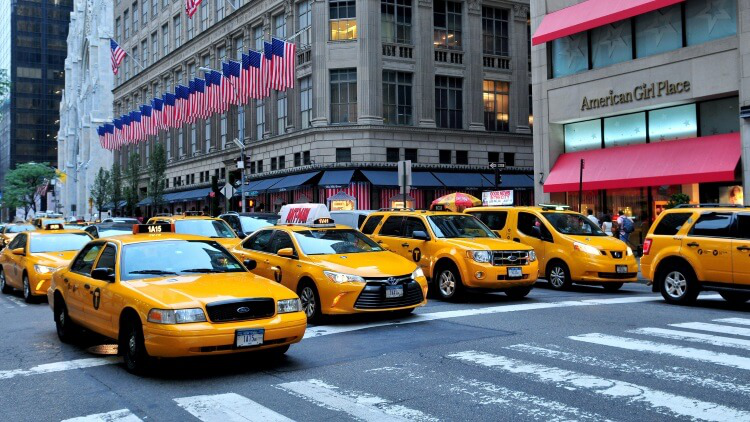

In [2]:
display(Image.open("yellow-cab.jpg"))

# Celem biznesowy: Rozwiązanie 3 problemów dla przedsiębiorstwa zajmującego się usługami taksówkowymi:


Pierwszy problem mikroekonomiczny: Znalezienie optymalnego kierunku ruchu "wolnego" taksówkarza, tak aby maksymalizować szansę zdobycia pasażera

Drugi problem makroekonomiczny: Optymalna alokacja taksówkarzy, tak aby minimalizować czas oczekiwania pasażerów na przewóz

Trzeci problem mikroekonomiczny: predykcja napiwku w zależności od przejazdu

# -----------------------------------------------------------------------------

# Analiza jakości danych źródłowych:

In [3]:
df4 = pd.read_parquet("yellow_tripdata_2009-01.parquet")

In [4]:
df4.head(10)

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         VTS  2009-01-04 02:52:00   2009-01-04 03:02:00                1   
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
4         DDS  2009-01-24 16:18:23   2009-01-24 16:24:56                1   
5         DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
6         DDS  2009-01-21 08:55:57   2009-01-21 09:05:42                1   
7         VTS  2009-01-04 04:31:00   2009-01-04 04:36:00                1   
8         CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
9         CMT  2009-01-05 18:53:13   2009-01-05 18:57:45                1   

   Trip_Distance  Start_Lon  Start_Lat  Rate_Code  store_and_forward  \
0           2.63 -73.991957  40.721567        NaN                NaN   
1           4.55 -73.982102  40.736290        NaN                NaN   
2          10.35 -74.002587  40.739748        NaN                NaN   
3           5.00 -73.974267  40.790955        NaN                NaN   
4           0.40 -74.001580  40.719382        NaN                NaN   
5           1.20 -73.989806  40.735006        NaN                NaN   
6           0.40 -73.984050  40.743544        NaN                NaN   
7           1.72 -73.992635  40.748362        NaN                NaN   
8           1.60 -73.969690  40.749244        NaN                NaN   
9           0.70 -73.955173  40.783044        NaN                NaN   

     End_Lon    End_Lat Payment_Type  Fare_Amt  surcharge  mta_tax  Tip_Amt  \
0 -73.993803  40.695922         CASH       8.9        0.5      NaN     0.00   
1 -73.955850  40.768030       Credit      12.1        0.5      NaN     2.00   
2 -73.869983  40.770225       Credit      23.7        0.0      NaN     4.74   
3 -73.996558  40.731849       CREDIT      14.9        0.5      NaN     3.05   
4 -74.008378  40.720350         CASH       3.7        0.0      NaN     0.00   
5 -73.985021  40.724494         CASH       6.1        0.5      NaN     0.00   
6 -73.980260  40.748926       CREDIT       5.7        0.0      NaN     1.00   
7 -73.995585  40.728307         CASH       6.1        0.5      NaN     0.00   
8 -73.990413  40.751082       Credit       8.7        0.0      NaN     1.30   
9 -73.958598  40.774822         Cash       5.9        0.0      NaN     0.00   

   Tolls_Amt  Total_Amt  
0        0.0       9.40  
1        0.0      14.60  
2        0.0      28.44  
3        0.0      18.45  
4        0.0       3.70  
5        0.0       6.60  
6        0.0       6.70  
7        0.0       6.60  
8        0.0      10.00  
9        0.0       5.90

# Opis danych źródłowych:

> vendor_name - zmienna kategoryczna określająca nazwę dostawcy rekordu TPEP

> Trip_Pickup_DateTime - zmienna opisująca początkowy czas przejazdu 

> Trip_Dropoff_DateTime - zmienna opisująca końcowy czas przejazdu

> Passenger_Count - zmienna dyskretna opisująca liczbę pasażerów podczas przewozu taksówkarskiego

> Trip_Distance	- zmienna ciągła opisująca dystans przebyty przez kierowcę taksówki

> Start_Lon	- Współrzędna początkowa długości geograficznej

> Start_Lat	- Współrzędna początkowa szerokości geograficznej

> Rate_Code - Ostateczny kod taryfy obowiązujący na koniec podróży

> store_and_forward	- Flaga wskazująca, czy rekord podróży był przechowywany w pamięci pojazdu przed wysłaniem do dostawcy ponieważ pojazd nie miał połączenia z serwerem.

> End_Lon	- Współrzędna końcowa długości geograficznej

> End_Lat	- Współrzędna końcowa szerokości geograficznej

> Payment_Type   - Zmienna kategoryczna opisująca sposób płatności za przejazd taksówkarski

> Fare_Amt - Opłata czasowo-odległościowa obliczona przez taksometr

> surcharge	- Różne dodatki i opłaty dodatkowe. Obecnie obejmuje tylko opłaty szczytowe i nocne w wysokości 0,50 USD i 1 USD

> MTA_tax - Podatek MTA w wysokości 0,50 USD, który jest automatycznie naliczany na podstawie obowiązującej taryfy

> Tip_Amt  - Kwota napiwku dla napiwków przy płatności kartą kredytową

> Tolls_Amt	- Łączna kwota wszystkich opłat drogowych zapłaconych podczas podróży

> Total_Amt - Całkowita kwota naliczona pasażerom. Nie obejmuje napiwków gotówkowych.


# Zrozumienie danych:

In [5]:
df4["vendor_name"].describe()

count     14092413
unique           3
top            VTS
freq       6848556
Name: vendor_name, dtype: object

In [6]:
df4["Trip_Pickup_DateTime"].describe()

count                14092413
unique                2283326
top       2009-01-24 22:57:00
freq                      358
Name: Trip_Pickup_DateTime, dtype: object

In [7]:
df4["Rate_Code"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Rate_Code, dtype: float64

In [8]:
df4["store_and_forward"].describe()

count    1224.000000
mean        0.009804
std         0.098568
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: store_and_forward, dtype: float64

In [9]:
df4.describe()

Passenger_Count  Trip_Distance     Start_Lon     Start_Lat  Rate_Code  \
count     1.409241e+07   1.409241e+07  1.409241e+07  1.409241e+07        0.0   
mean      1.700110e+00   2.557776e+00 -7.285285e+01  4.013562e+01        NaN   
std       1.262284e+00   2.947924e+00  9.095511e+00  4.988151e+00        NaN   
min       0.000000e+00   0.000000e+00 -7.754500e+02 -7.335107e+00        NaN   
25%       1.000000e+00   9.700000e-01 -7.399147e+01  4.073638e+01        NaN   
50%       1.000000e+00   1.610000e+00 -7.398142e+01  4.075390e+01        NaN   
75%       2.000000e+00   2.900000e+00 -7.396749e+01  4.076805e+01        NaN   
max       1.130000e+02   5.000000e+01  3.555913e+03  9.355253e+02        NaN   

       store_and_forward       End_Lon       End_Lat      Fare_Amt  \
count        1224.000000  1.409241e+07  1.409241e+07  1.409241e+07   
mean            0.009804 -7.287128e+01  4.014641e+01  9.502456e+00   
std             0.098568  8.970819e+00  4.962724e+00  7.208776e+00   
min             0.000000 -7.843000e+02 -7.335107e+00  2.500000e+00   
25%             0.000000 -7.399099e+01  4.073546e+01  5.400000e+00   
50%             0.000000 -7.397981e+01  4.075420e+01  7.300000e+00   
75%             0.000000 -7.396409e+01  4.076920e+01  1.060000e+01   
max             1.000000  1.014050e-01  1.809958e+03  2.000000e+02   

          surcharge  mta_tax       Tip_Amt     Tolls_Amt     Total_Amt  
count  1.409241e+07      0.0  1.409241e+07  1.409241e+07  1.409241e+07  
mean   1.789869e-01      NaN  4.638160e-01  1.153109e-01  1.026336e+01  
std    3.188321e-01      NaN  1.294150e+00  7.304974e-01  8.183438e+00  
min    0.000000e+00      NaN  0.000000e+00  0.000000e+00  2.500000e+00  
25%    0.000000e+00      NaN  0.000000e+00  0.000000e+00  5.800000e+00  
50%    0.000000e+00      NaN  0.000000e+00  0.000000e+00  7.900000e+00  
75%    5.000000e-01      NaN  0.000000e+00  0.000000e+00  1.140000e+01  
max    5.000000e+00      NaN  1.000000e+02  2.000000e+01  2.340000e+02

In [10]:
df4[df4.isnull().any(axis=1)]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
0                VTS  2009-01-04 02:52:00   2009-01-04 03:02:00   
1                VTS  2009-01-04 03:31:00   2009-01-04 03:38:00   
2                VTS  2009-01-03 15:43:00   2009-01-03 15:57:00   
3                DDS  2009-01-01 20:52:58   2009-01-01 21:14:00   
4                DDS  2009-01-24 16:18:23   2009-01-24 16:24:56   
...              ...                  ...                   ...   
14092408         VTS  2009-01-27 14:36:00   2009-01-27 14:46:00   
14092409         VTS  2009-01-27 13:56:00   2009-01-27 14:02:00   
14092410         CMT  2009-01-23 08:39:44   2009-01-23 09:02:15   
14092411         VTS  2009-01-24 23:05:00   2009-01-24 23:15:00   
14092412         CMT  2009-01-23 14:39:02   2009-01-23 15:35:15   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat  Rate_Code  \
0                       1           2.63 -73.991957  40.721567        NaN   
1                       3           4.55 -73.982102  40.736290        NaN   
2                       5          10.35 -74.002587  40.739748        NaN   
3                       1           5.00 -73.974267  40.790955        NaN   
4                       1           0.40 -74.001580  40.719382        NaN   
...                   ...            ...        ...        ...        ...   
14092408                5           0.89 -73.982013  40.743330        NaN   
14092409                1           1.94 -73.972788  40.761988        NaN   
14092410                1           3.80 -73.977467  40.751861        NaN   
14092411                3           3.85 -73.981295  40.753000        NaN   
14092412                1          17.30   0.000000   0.000000        NaN   

          store_and_forward    End_Lon    End_Lat Payment_Type  Fare_Amt  \
0                       NaN -73.993803  40.695922         CASH       8.9   
1                       NaN -73.955850  40.768030       Credit      12.1   
2                       NaN -73.869983  40.770225       Credit      23.7   
3                       NaN -73.996558  40.731849       CREDIT      14.9   
4                       NaN -74.008378  40.720350         CASH       3.7   
...                     ...        ...        ...          ...       ...   
14092408                NaN -73.994328  40.750130         CASH       6.5   
14092409                NaN -73.951477  40.778217       Credit       8.1   
14092410                NaN -74.009913  40.713470         Cash      14.5   
14092411                NaN -73.949453  40.779520         CASH      10.9   
14092412                NaN   0.000000   0.000000       Credit      45.0   

          surcharge  mta_tax  Tip_Amt  Tolls_Amt  Total_Amt  
0               0.5      NaN     0.00        0.0       9.40  
1               0.5      NaN     2.00        0.0      14.60  
2               0.0      NaN     4.74        0.0      28.44  
3               0.5      NaN     3.05        0.0      18.45  
4               0.0      NaN     0.00        0.0       3.70  
...             ...      ...      ...        ...        ...  
14092408        0.0      NaN     0.00        0.0       6.50  
14092409        0.0      NaN     1.90        0.0      10.00  
14092410        0.0      NaN     0.00        0.0      14.50  
14092411        0.5      NaN     0.00        0.0      11.40  
14092412        0.0      NaN     5.00        0.0      50.00  

[14092413 rows x 18 columns]

In [11]:
df4["Payment_Type"].describe()

count     14092413
unique           6
top           CASH
freq       6024471
Name: Payment_Type, dtype: object

In [12]:
df4["Payment_Type"].unique()

array(['CASH', 'Credit', 'CREDIT', 'Cash', 'No Charge', 'Dispute'],
      dtype=object)

In [13]:
df4['Trip_Pickup_DateTime'] = pd.to_datetime(df4['Trip_Pickup_DateTime'], errors='coerce')
df4['Trip_Dropoff_DateTime'] = pd.to_datetime(df4['Trip_Dropoff_DateTime'], errors='coerce')
print(df4.dtypes)

vendor_name                      object
Trip_Pickup_DateTime     datetime64[ns]
Trip_Dropoff_DateTime    datetime64[ns]
Passenger_Count                   int64
Trip_Distance                   float64
Start_Lon                       float64
Start_Lat                       float64
Rate_Code                       float64
store_and_forward               float64
End_Lon                         float64
End_Lat                         float64
Payment_Type                     object
Fare_Amt                        float64
surcharge                       float64
mta_tax                         float64
Tip_Amt                         float64
Tolls_Amt                       float64
Total_Amt                       float64
dtype: object


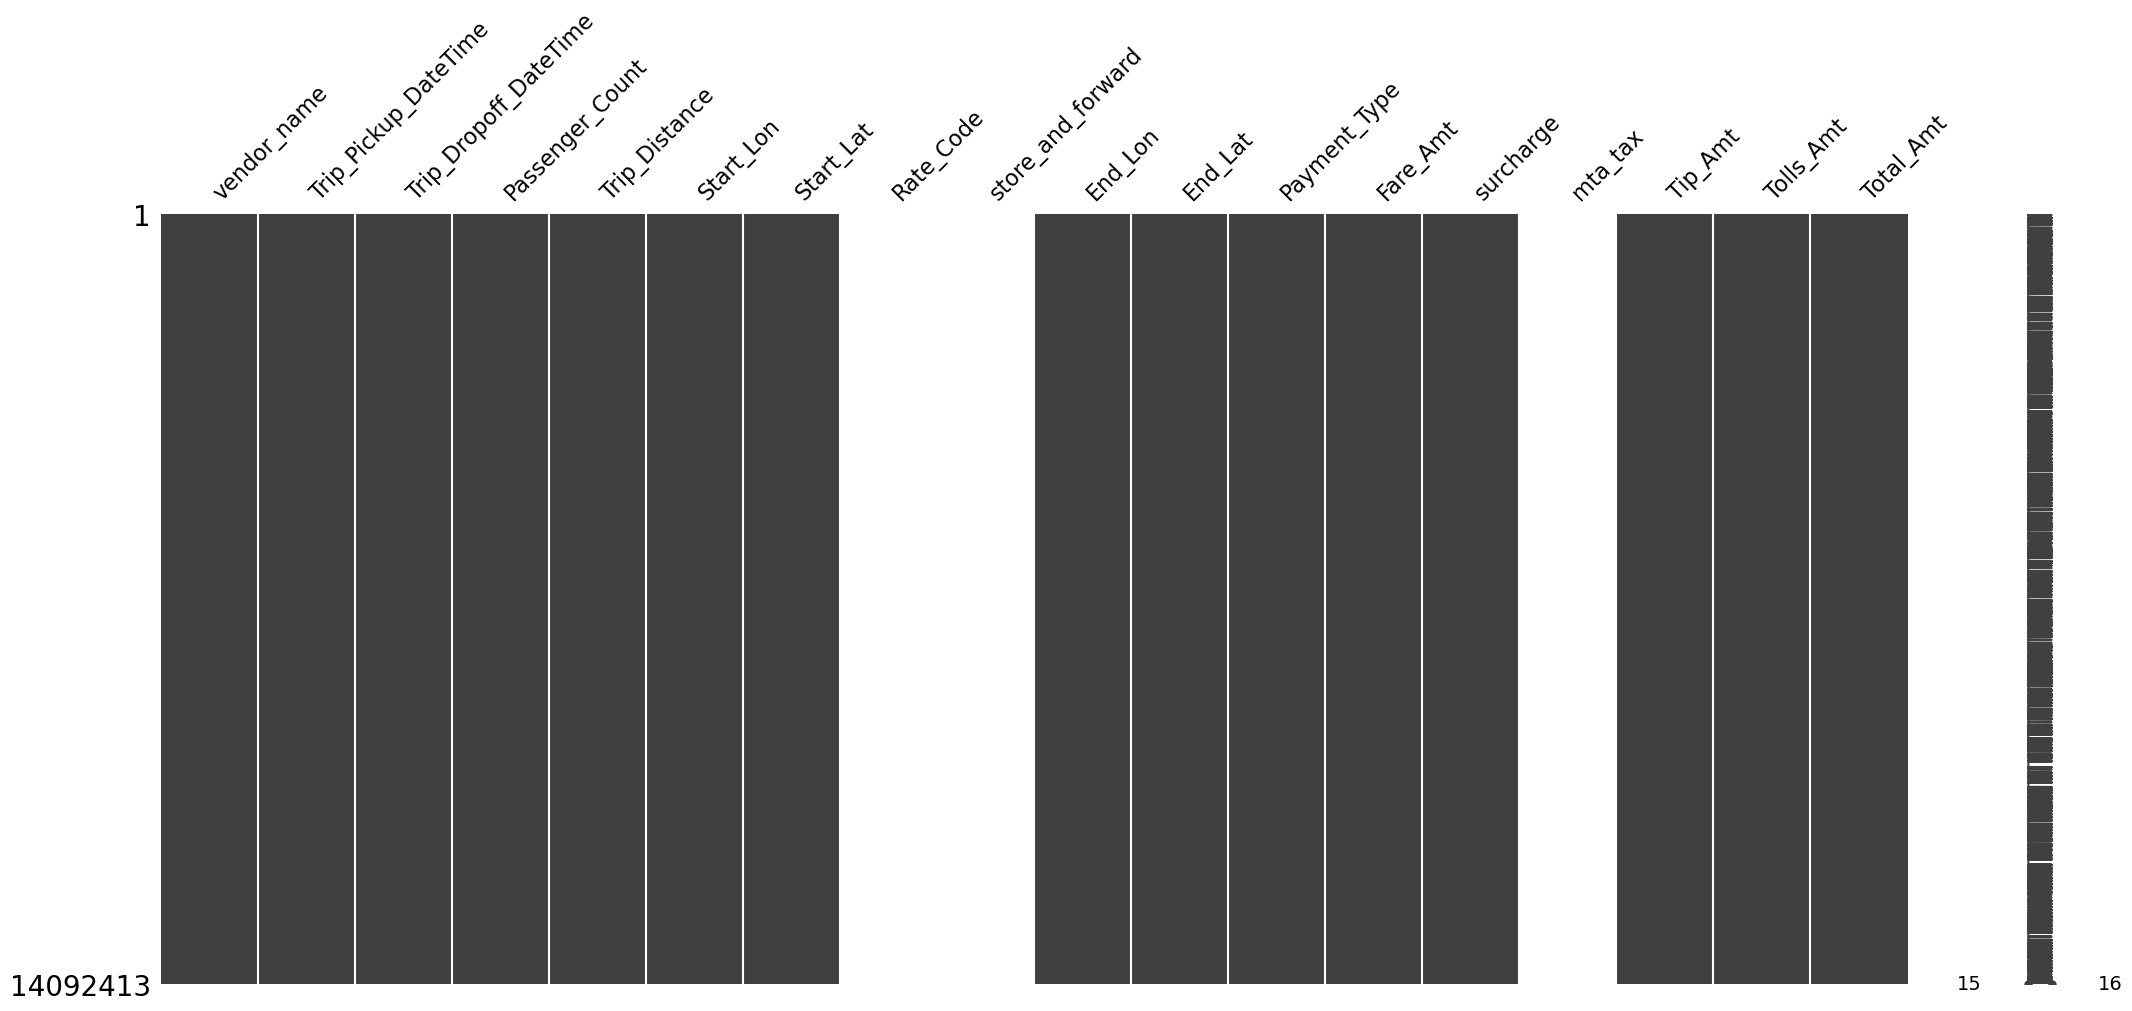

In [14]:
msno.matrix(df4)
plt.show()

# -----------------------------------------------------------------------------

# Porzucenie kolumn prawie w pełni pustych oraz nielicznych wierszy w któych występują braki:

In [15]:
df4.drop(['Rate_Code','store_and_forward','mta_tax'], axis=1, inplace=True)

# -----------------------------------------------------------------------------

# Usuwanie duplikatów:

In [16]:
df4.duplicated().value_counts()

False    14092382
True           31
Name: count, dtype: int64

In [17]:
df4 = df4.drop_duplicates()

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


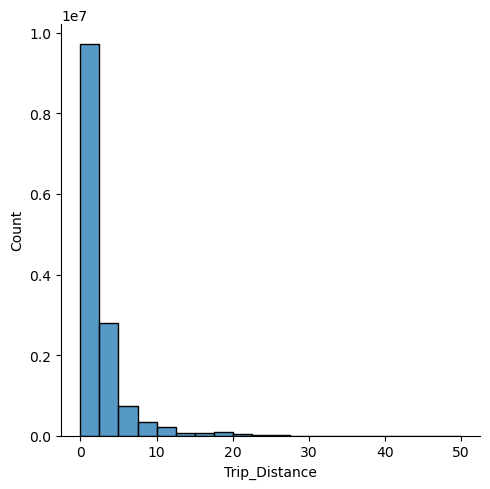

In [18]:
sns.displot(df4["Trip_Distance"], bins=20)
plt.show()

In [19]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         VTS  2009-01-04 02:52:00   2009-01-04 03:02:00                1   
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
4         DDS  2009-01-24 16:18:23   2009-01-24 16:24:56                1   

   Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
0           2.63 -73.991957  40.721567 -73.993803  40.695922         CASH   
1           4.55 -73.982102  40.736290 -73.955850  40.768030       Credit   
2          10.35 -74.002587  40.739748 -73.869983  40.770225       Credit   
3           5.00 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
4           0.40 -74.001580  40.719382 -74.008378  40.720350         CASH   

   Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt  
0       8.9        0.5     0.00        0.0       9.40  
1      12.1        0.5     2.00        0.0      14.60  
2      23.7        0.0     4.74        0.0      28.44  
3      14.9        0.5     3.05        0.0      18.45  
4       3.7        0.0     0.00        0.0       3.70

# -----------------------------------------------------------------------------

# Usuwanie skrajnie dużych wartości pasager count

In [20]:
df4["Passenger_Count"].max()

113

In [21]:
df4["Passenger_Count"].value_counts()

Passenger_Count
1      9493395
2      2347162
5      1263352
3       624652
4       299288
6        63814
0          718
113          1
Name: count, dtype: int64

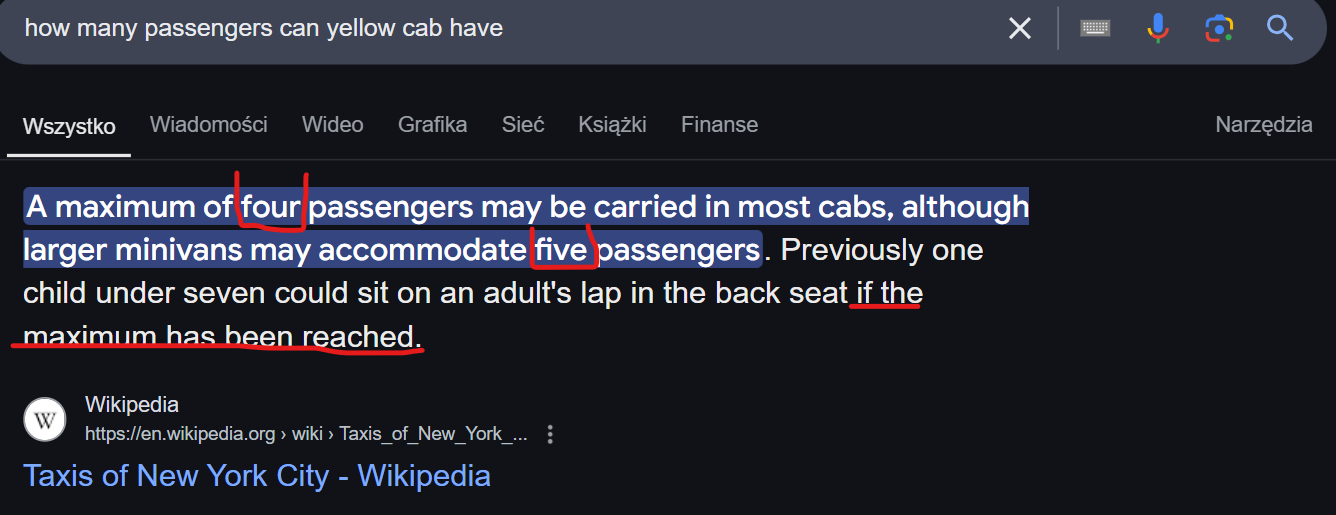

In [22]:
display(Image.open("yellow_cab_limits.png"))
# zatem ponieważ dane pochodzą z 2009 roku jest to możliwe by poszczególne transporty posiadały 6 pasażerów

In [23]:
df4 = df4[df4["Passenger_Count"]<=6]
df4 = df4[df4["Passenger_Count"]>0]

# -----------------------------------------------------------------------------

# Wstępne ograniczanie liczbowe współrzędnych w naszych danych:

In [24]:
print(df4["Start_Lat"].max())
print(df4["Start_Lat"].min())
print(df4["Start_Lon"].max())
print(df4["Start_Lon"].min())

409.133332
-7.335107
0.098127
-775.45


In [25]:
nyc_map = gpd.read_file("new-york-city-boroughs.geojson")
min_lon, min_lat, max_lon, max_lat = nyc_map.total_bounds
print(f"🔹 Minimalna długość geograficzna (Longitude): {min_lon}")
print(f"🔹 Maksymalna długość geograficzna (Longitude): {max_lon}")
print(f"🔹 Minimalna szerokość geograficzna (Latitude): {min_lat}")
print(f"🔹 Maksymalna szerokość geograficzna (Latitude): {max_lat}")
#wiadomo że kształt nowego yorku nie jest kwadratowy,
#ale ze względu na złożność obliczeniową zmuszony jestem do przyblizen

🔹 Minimalna długość geograficzna (Longitude): -74.255591
🔹 Maksymalna długość geograficzna (Longitude): -73.700009
🔹 Minimalna szerokość geograficzna (Latitude): 40.496115
🔹 Maksymalna szerokość geograficzna (Latitude): 40.915533


In [26]:
df4 = df4[df4["Start_Lat"]>=40.496115]
df4 = df4[df4["Start_Lat"]<=40.915533]
df4 = df4[df4["Start_Lon"]>=-74.255591]
df4 = df4[df4["Start_Lon"]<=-73.700009]

In [27]:
df4.count()

vendor_name              13844268
Trip_Pickup_DateTime     13844268
Trip_Dropoff_DateTime    13844268
Passenger_Count          13844268
Trip_Distance            13844268
Start_Lon                13844268
Start_Lat                13844268
End_Lon                  13844268
End_Lat                  13844268
Payment_Type             13844268
Fare_Amt                 13844268
surcharge                13844268
Tip_Amt                  13844268
Tolls_Amt                13844268
Total_Amt                13844268
dtype: int64

# -----------------------------------------------------------------------------

# Maksymalna odległość na którą mogą się oddalić taksówki to (maxtrip + skrajne wartości brzegów Nowego Yorku), także wykluczamy te współrzędne z naszych danych:

In [28]:
df4["Trip_Distance"].max()

50.0

In [29]:
def miles_to_latitude_degrees(miles, reference_lat=40.7128):
    start_point = (reference_lat, -74.0060)  
    end_point = geodesic(miles=miles).destination(start_point, bearing=0)
    return abs(end_point.latitude - start_point[0])
miles = 50
latitude_degrees = miles_to_latitude_degrees(miles)
print(f"{miles} mil = {latitude_degrees:.4f} stopni szerokości geograficznej")

50 mil = 0.7246 stopni szerokości geograficznej


In [30]:
df4 = df4[df4["End_Lat"]>=40.496115-latitude_degrees]
df4 = df4[df4["End_Lat"]<=40.915533+latitude_degrees]
df4 = df4[df4["End_Lon"]>=-74.255591-latitude_degrees]
df4 = df4[df4["End_Lon"]<=-73.700009+latitude_degrees]

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


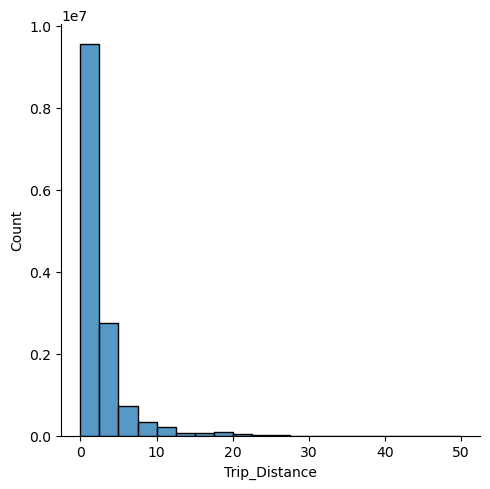

In [31]:
sns.displot(df4["Trip_Distance"],bins=20)

# -----------------------------------------------------------------------------

# Wymiary Nowego Yorku są na tyle duże, że możemy uwzględnić odległości trasy 50mil

In [32]:
df4.columns

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat', 'End_Lon',
       'End_Lat', 'Payment_Type', 'Fare_Amt', 'surcharge', 'Tip_Amt',
       'Tolls_Amt', 'Total_Amt'],
      dtype='object')

In [33]:
df4["Total_Amt"].describe()

count    1.384350e+07
mean     1.025078e+01
std      8.109274e+00
min      2.500000e+00
25%      5.800000e+00
50%      7.900000e+00
75%      1.140000e+01
max      2.330000e+02
Name: Total_Amt, dtype: float64

In [34]:
df4["Trip_time"] = df4["Trip_Dropoff_DateTime"] - df4["Trip_Pickup_DateTime"]

In [35]:
df4["Trip_time"].describe()

count                     13843496
mean     0 days 00:11:01.942963468
std      0 days 00:25:48.704458479
min              -1 days +00:01:00
25%                0 days 00:05:12
50%                0 days 00:09:00
75%                0 days 00:14:00
max                7 days 11:10:30
Name: Trip_time, dtype: object

In [36]:
df4[df4["Trip_time"]<pd.Timedelta(0)].count()

vendor_name              171331
Trip_Pickup_DateTime     171331
Trip_Dropoff_DateTime    171331
Passenger_Count          171331
Trip_Distance            171331
Start_Lon                171331
Start_Lat                171331
End_Lon                  171331
End_Lat                  171331
Payment_Type             171331
Fare_Amt                 171331
surcharge                171331
Tip_Amt                  171331
Tolls_Amt                171331
Total_Amt                171331
Trip_time                171331
dtype: int64

In [37]:
df4 = df4[df4["Trip_time"]>pd.Timedelta(0)]

In [38]:
df4["Trip_time"].nlargest(100).head(100)

4212498    7 days 11:10:30
11450584   7 days 00:50:55
11700302   5 days 01:57:32
1132713    3 days 21:03:51
7150295    3 days 09:13:31
                 ...      
732117     0 days 23:58:00
737591     0 days 23:58:00
1215691    0 days 23:58:00
1361159    0 days 23:58:00
1556500    0 days 23:58:00
Name: Trip_time, Length: 100, dtype: timedelta64[ns]

In [39]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         VTS  2009-01-04 02:52:00   2009-01-04 03:02:00                1   
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
4         DDS  2009-01-24 16:18:23   2009-01-24 16:24:56                1   

   Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
0           2.63 -73.991957  40.721567 -73.993803  40.695922         CASH   
1           4.55 -73.982102  40.736290 -73.955850  40.768030       Credit   
2          10.35 -74.002587  40.739748 -73.869983  40.770225       Credit   
3           5.00 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
4           0.40 -74.001580  40.719382 -74.008378  40.720350         CASH   

   Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  
0       8.9        0.5     0.00        0.0       9.40 0 days 00:10:00  
1      12.1        0.5     2.00        0.0      14.60 0 days 00:07:00  
2      23.7        0.0     4.74        0.0      28.44 0 days 00:14:00  
3      14.9        0.5     3.05        0.0      18.45 0 days 00:21:02  
4       3.7        0.0     0.00        0.0       3.70 0 days 00:06:33

# -----------------------------------------------------------------------------

# Sprawdzenie średniej prędkości taksówki na odcinku, tak żeby wyeliminować nieprawdopodobnie skrajne wartości: min. 5mil/h max. 50mil/h

In [40]:
df4['Trip_time_hours'] = df4['Trip_time'].dt.total_seconds() / 3600  
df4['Trip_velocity'] = df4['Trip_Distance'] / df4['Trip_time_hours']

#https://www.transport-publiczny.pl/wiadomosci/nowy-jork-na-manhattanie-rower-szybszy-niz-taksowka-52215.html


Z danych wynika że średnia predkość może być dosyć niska ze względu na liczne korki, ale trzeba też uwzględnić że w nocy tych korków nie ma dlatego średnie prędkości mogą być większe

In [41]:
df4[df4["Trip_velocity"]>50]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
193              VTS  2009-01-24 22:14:00   2009-01-24 22:25:00   
245              VTS  2009-01-26 09:28:00   2009-01-26 09:29:00   
492              VTS  2009-01-13 21:59:00   2009-01-13 22:00:00   
556              VTS  2009-01-11 01:11:00   2009-01-11 01:17:00   
626              VTS  2009-01-12 19:51:00   2009-01-12 19:52:00   
...              ...                  ...                   ...   
14091614         VTS  2009-01-28 16:13:00   2009-01-28 16:15:00   
14091630         VTS  2009-01-18 16:47:00   2009-01-18 16:50:00   
14091967         VTS  2009-01-16 18:28:00   2009-01-16 18:30:00   
14092058         VTS  2009-01-16 01:34:00   2009-01-16 01:35:00   
14092189         VTS  2009-01-29 12:45:00   2009-01-29 12:46:00   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
193                     5          10.11 -73.977150  40.754292 -73.921962   
245                     1           1.41 -73.994047  40.752098 -73.995035   
492                     1           1.71 -73.984775  40.764922 -73.981390   
556                     5           5.29 -73.991217  40.770375 -73.943697   
626                     5           1.16 -73.956570  40.784612 -73.950215   
...                   ...            ...        ...        ...        ...   
14091614                1           1.78 -73.972612  40.785835 -73.984103   
14091630                1           2.65 -73.968757  40.767363 -73.992885   
14091967                1           2.68 -73.961007  40.765573 -73.978673   
14092058                1           2.74 -73.969228  40.758298 -73.998947   
14092189                1           0.93 -73.985777  40.730317 -73.989828   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
193       40.867485       Credit      24.1        0.5      3.0        0.0   
245       40.743893       Credit       6.9        0.0      2.0        0.0   
492       40.747140       Credit       6.9        0.5      3.0        0.0   
556       40.810135         CASH      13.3        0.5      0.0        0.0   
626       40.775743         CASH       4.9        1.0      0.0        0.0   
...             ...          ...       ...        ...      ...        ...   
14091614  40.765172       Credit       6.5        1.0      1.0        0.0   
14091630  40.736792         CASH       8.5        0.0      0.0        0.0   
14091967  40.737047       Credit       9.3        1.0      2.0        0.0   
14092058  40.737582       Credit       8.5        0.5      2.0        0.0   
14092189  40.740138       Credit       5.7        0.0      2.0        0.0   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  
193            27.6 0 days 00:11:00         0.183333      55.145455  
245             8.9 0 days 00:01:00         0.016667      84.600000  
492            10.4 0 days 00:01:00         0.016667     102.600000  
556            13.8 0 days 00:06:00         0.100000      52.900000  
626             5.9 0 days 00:01:00         0.016667      69.600000  
...             ...             ...              ...            ...  
14091614        8.5 0 days 00:02:00         0.033333      53.400000  
14091630        8.5 0 days 00:03:00         0.050000      53.000000  
14091967       12.3 0 days 00:02:00         0.033333      80.400000  
14092058       11.0 0 days 00:01:00         0.016667     164.400000  
14092189        7.7 0 days 00:01:00         0.016667      55.800000  

[98754 rows x 18 columns]

In [42]:
df4[df4["Trip_velocity"]<5]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
4                DDS  2009-01-24 16:18:23   2009-01-24 16:24:56   
6                DDS  2009-01-21 08:55:57   2009-01-21 09:05:42   
48               CMT  2009-01-06 13:05:14   2009-01-06 13:15:14   
83               CMT  2009-01-06 16:52:38   2009-01-06 16:53:05   
92               CMT  2009-01-03 15:00:23   2009-01-03 15:10:33   
...              ...                  ...                   ...   
14092290         VTS  2009-01-15 23:20:00   2009-01-15 23:25:00   
14092291         VTS  2009-01-15 20:44:00   2009-01-15 20:48:00   
14092309         VTS  2009-01-15 21:34:00   2009-01-15 21:56:00   
14092360         VTS  2009-01-25 19:45:00   2009-01-25 19:59:00   
14092392         VTS  2009-01-25 13:33:00   2009-01-25 13:50:00   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
4                       1          0.400 -74.001580  40.719382 -74.008378   
6                       1          0.400 -73.984050  40.743544 -73.980260   
48                      1          0.500 -73.965083  40.754974 -73.970289   
83                      4          0.000 -73.946700  40.744697 -73.946700   
92                      2          0.700 -73.958931  40.753357 -73.958931   
...                   ...            ...        ...        ...        ...   
14092290                2          0.068 -73.979662  40.776282 -73.989168   
14092291                1          0.067 -74.003902  40.725648 -73.999860   
14092309                1          0.476 -73.991610  40.729693 -73.959622   
14092360                1          0.000 -73.924203  40.744068 -73.986923   
14092392                5          0.930 -73.987288  40.739983 -73.983332   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
4         40.720350         CASH       3.7        0.0      0.0        0.0   
6         40.748926       CREDIT       5.7        0.0      1.0        0.0   
48        40.759571         Cash       6.5        0.0      0.0        0.0   
83        40.744697         Cash       3.5        0.0      0.0        0.0   
92        40.753357         Cash       6.5        0.0      0.0        0.0   
...             ...          ...       ...        ...      ...        ...   
14092290  40.777118         CASH       4.9        0.5      0.0        0.0   
14092291  40.734568         CASH       3.7        0.5      0.0        0.0   
14092309  40.676078       Credit      16.5        0.5      2.0        0.0   
14092360  40.755940         CASH       7.7        0.0      0.0        0.0   
14092392  40.750313       Credit       5.7        0.0      2.0        0.0   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  
4               3.7 0 days 00:06:33         0.109167       3.664122  
6               6.7 0 days 00:09:45         0.162500       2.461538  
48              6.5 0 days 00:10:00         0.166667       3.000000  
83              3.5 0 days 00:00:27         0.007500       0.000000  
92              6.5 0 days 00:10:10         0.169444       4.131148  
...             ...             ...              ...            ...  
14092290        5.4 0 days 00:05:00         0.083333       0.816000  
14092291        4.2 0 days 00:04:00         0.066667       1.005000  
14092309       19.0 0 days 00:22:00         0.366667       1.298182  
14092360        7.7 0 days 00:14:00         0.233333       0.000000  
14092392        7.7 0 days 00:17:00         0.283333       3.282353  

[569135 rows x 18 columns]

In [43]:
df4 = df4[df4["Trip_velocity"]<50]
df4 = df4[df4["Trip_velocity"]>5]

# -----------------------------------------------------------------------------

# Sprawdzenie czasu przejazdu taksówkarskiego i usunięcię wartości ujemnych, małych (do 5min) i skrajnie dużych (powyżej 3h)

In [44]:
df4["Trip_time"].describe()

count                     12920477
mean     0 days 00:10:50.743113276
std      0 days 00:07:40.459346554
min                0 days 00:00:08
25%                0 days 00:05:40
50%                0 days 00:09:00
75%                0 days 00:14:00
max                0 days 09:28:40
Name: Trip_time, dtype: object

In [45]:
df4[df4["Trip_time"]<pd.Timedelta(minutes=5)]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
9                CMT  2009-01-05 18:53:13   2009-01-05 18:57:45   
10               CMT  2009-01-05 08:15:38   2009-01-05 08:16:44   
17               CMT  2009-01-05 07:49:57   2009-01-05 07:54:11   
24               CMT  2009-01-03 01:34:33   2009-01-03 01:35:10   
27               CMT  2009-01-04 01:04:38   2009-01-04 01:09:19   
...              ...                  ...                   ...   
14092361         VTS  2009-01-26 16:55:00   2009-01-26 16:57:00   
14092369         VTS  2009-01-26 06:33:00   2009-01-26 06:35:00   
14092371         VTS  2009-01-25 22:13:00   2009-01-25 22:17:00   
14092387         VTS  2009-01-26 19:58:00   2009-01-26 20:00:00   
14092400         VTS  2009-01-27 13:12:00   2009-01-27 13:14:00   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
9                       1           0.70 -73.955173  40.783044 -73.958598   
10                      1           0.30 -73.986824  40.750893 -73.984118   
17                      1           1.00 -73.982457  40.731475 -73.973011   
24                      1           0.10 -73.956573  40.716945 -73.958689   
27                      2           1.20 -73.976983  40.747167 -73.964459   
...                   ...            ...        ...        ...        ...   
14092361                5           0.84 -73.959547  40.763285 -73.951865   
14092369                1           0.98 -73.989290  40.747675 -73.982900   
14092371                5           0.89 -73.988563  40.737612 -73.979203   
14092387                6           0.95 -74.009152  40.716670 -74.006797   
14092400                1           1.59 -73.874552  40.774215 -73.895872   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
9         40.774822         Cash       5.9        0.0      0.0        0.0   
10        40.751437         Cash       2.9        0.0      0.0        0.0   
17        40.743387       Credit       4.5        0.0      1.0        0.0   
24        40.714976         Cash       3.0        0.0      0.0        0.0   
27        40.758917       Credit       5.8        0.0      1.0        0.0   
...             ...          ...       ...        ...      ...        ...   
14092361  40.773653         CASH       4.1        1.0      0.0        0.0   
14092369  40.756298         CASH       4.5        0.0      0.0        0.0   
14092371  40.746420         CASH       4.5        0.5      0.0        0.0   
14092387  40.730150         CASH       4.1        1.0      0.0        0.0   
14092400  40.766795         CASH      45.0        0.0      0.0        0.0   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  
9               5.9 0 days 00:04:32         0.075556       9.264706  
10              2.9 0 days 00:01:06         0.018333      16.363636  
17              5.5 0 days 00:04:14         0.070556      14.173228  
24              3.0 0 days 00:00:37         0.010278       9.729730  
27              6.8 0 days 00:04:41         0.078056      15.373665  
...             ...             ...              ...            ...  
14092361        5.1 0 days 00:02:00         0.033333      25.200000  
14092369        4.5 0 days 00:02:00         0.033333      29.400000  
14092371        5.0 0 days 00:04:00         0.066667      13.350000  
14092387        5.1 0 days 00:02:00         0.033333      28.500000  
14092400       45.0 0 days 00:02:00         0.033333      47.700000  

[2388466 rows x 18 columns]

In [46]:
df4 = df4[df4["Trip_time"]>pd.Timedelta(minutes=5)]

In [47]:
df4[df4["Trip_time"]>pd.Timedelta(hours=3)]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
191189           CMT  2009-01-01 17:28:23   2009-01-01 22:46:25   
338936           DDS  2009-01-13 17:53:03   2009-01-13 21:24:40   
554981           VTS  2009-01-18 08:11:00   2009-01-18 12:17:00   
579541           CMT  2009-01-31 21:22:48   2009-02-01 02:33:49   
869520           CMT  2009-01-04 01:45:27   2009-01-04 05:08:07   
...              ...                  ...                   ...   
13226832         CMT  2009-01-06 21:35:00   2009-01-07 03:19:06   
13499117         DDS  2009-01-22 11:09:29   2009-01-22 15:19:13   
13570994         CMT  2009-01-13 19:57:46   2009-01-14 04:52:12   
13623972         CMT  2009-01-14 12:03:05   2009-01-14 15:20:28   
13957561         CMT  2009-01-17 11:45:02   2009-01-17 14:50:22   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
191189                  1          30.10 -74.028602  40.622824 -74.027480   
338936                  1          24.90 -73.776727  40.645136 -73.871766   
554981                  5          41.33 -74.004238  40.737878 -73.947608   
579541                  1          49.90 -73.963161  40.794169 -73.963070   
869520                  2          35.50 -73.960695  40.648717 -73.957487   
...                   ...            ...        ...        ...        ...   
13226832                1          36.40 -73.961004  40.757482 -73.948235   
13499117                1          27.50 -73.988693  40.777842 -73.781844   
13570994                1          45.70 -73.777196  40.644966 -73.955702   
13623972                1          16.60 -73.782198  40.644732 -73.980347   
13957561                1          20.90 -73.973555  40.755490 -73.985132   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
191189    40.623965         Cash       3.4        0.0     0.00       0.00   
338936    40.754164       CREDIT      54.9        1.0    10.00       4.15   
554981    40.781723       Credit      45.0        0.0     7.00       4.15   
579541    40.794106       Credit       3.0        0.0     1.00      13.00   
869520    40.640533         Cash     126.6        0.0     0.00       0.00   
...             ...          ...       ...        ...      ...        ...   
13226832  40.724463         Cash       3.0        0.0     0.00       0.00   
13499117  40.644777         CASH      45.0        0.0     0.00       0.00   
13570994  40.651234         Cash       3.0        0.0     0.00       0.00   
13623972  40.744328       Credit      45.0        0.0     7.37       4.15   
13957561  40.759366       Credit      94.5        0.0    14.17       0.00   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  
191189         3.40 0 days 05:18:02         5.300556       5.678650  
338936        70.05 0 days 03:31:37         3.526944       7.059935  
554981        56.15 0 days 04:06:00         4.100000      10.080488  
579541        17.00 0 days 05:11:01         5.183611       9.626494  
869520       126.60 0 days 03:22:40         3.377778      10.509868  
...             ...             ...              ...            ...  
13226832       3.00 0 days 05:44:06         5.735000       6.346992  
13499117      45.00 0 days 04:09:44         4.162222       6.607048  
13570994       3.00 0 days 08:54:26         8.907222       5.130668  
13623972      56.52 0 days 03:17:23         3.289722       5.046019  
13957561     108.67 0 days 03:05:20         3.088889       6.766187  

[129 rows x 18 columns]

In [48]:
df4 = df4[df4["Trip_time"]<pd.Timedelta(hours=3)]

In [49]:
df4["surcharge"].value_counts()

surcharge
0.0    7464814
0.5    1734593
1.0     844728
Name: count, dtype: int64

# -----------------------------------------------------------------------------

# Sprawdzenie czy cena za km jest proporcjonalna do ceny za przejazd (uwzględniając jakiś próg błędu)

In [50]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         VTS  2009-01-04 02:52:00   2009-01-04 03:02:00                1   
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5         DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   

   Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
0           2.63 -73.991957  40.721567 -73.993803  40.695922         CASH   
1           4.55 -73.982102  40.736290 -73.955850  40.768030       Credit   
2          10.35 -74.002587  40.739748 -73.869983  40.770225       Credit   
3           5.00 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5           1.20 -73.989806  40.735006 -73.985021  40.724494         CASH   

   Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
0       8.9        0.5     0.00        0.0       9.40 0 days 00:10:00   
1      12.1        0.5     2.00        0.0      14.60 0 days 00:07:00   
2      23.7        0.0     4.74        0.0      28.44 0 days 00:14:00   
3      14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5       6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   

   Trip_time_hours  Trip_velocity  
0         0.166667      15.780000  
1         0.116667      39.000000  
2         0.233333      44.357143  
3         0.350556      14.263074  
5         0.126667       9.473684

# Ponieważ system opłatowy jest dosyć skompikowany przyjmiemy prostą zależność liniową, aby uprościć system opłat:

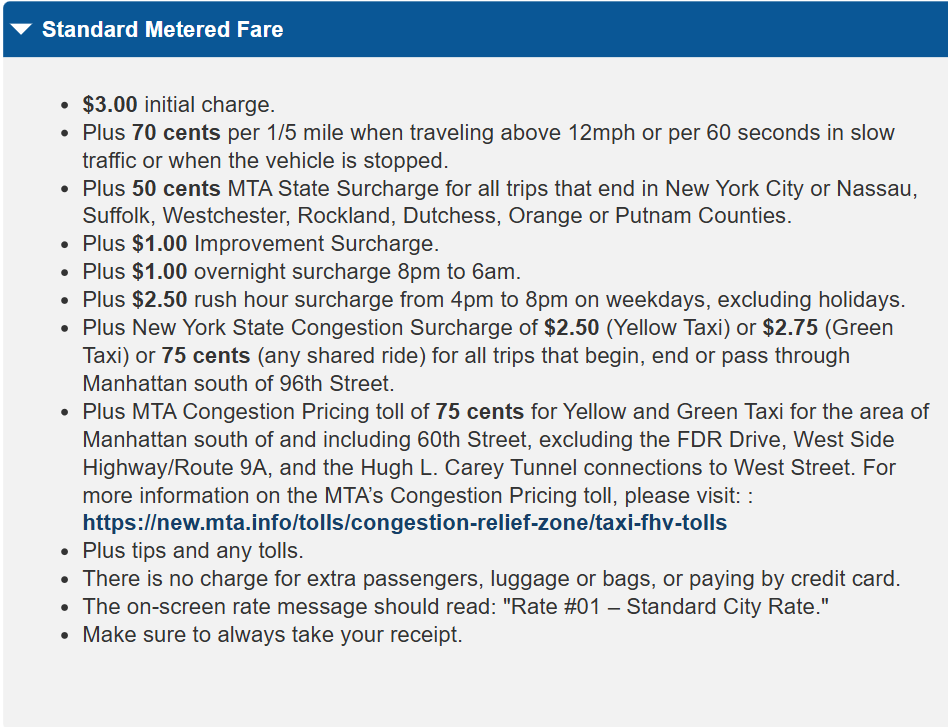

In [51]:
display(Image.open("standard_meter_fees.png"))
# dane aktualne cenowe ale ponieważ system obliczania jest dosyc skomplikowany, po prostu odrzucimy skrajne wartości

In [52]:
df4["price_per_mile"] = (df4["Fare_Amt"]-3)/df4["Trip_Distance"]

In [53]:
df4[df4["price_per_mile"]>5]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
977              VTS  2009-01-14 09:48:00   2009-01-14 09:56:00   
1261             CMT  2009-01-15 19:20:44   2009-01-15 19:34:05   
1560             CMT  2009-01-14 19:38:34   2009-01-14 19:59:10   
2538             VTS  2009-01-14 13:15:00   2009-01-14 13:22:00   
2812             CMT  2009-01-21 17:52:53   2009-01-21 18:05:51   
...              ...                  ...                   ...   
14090658         CMT  2009-01-10 14:05:55   2009-01-10 14:11:16   
14091079         CMT  2009-01-09 17:09:58   2009-01-09 17:19:17   
14091092         VTS  2009-01-14 23:35:00   2009-01-14 23:48:00   
14091823         VTS  2009-01-15 23:28:00   2009-01-15 23:46:00   
14091857         CMT  2009-01-25 11:08:24   2009-01-25 11:14:22   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
977                     2          0.930 -73.994943  40.750448 -73.994943   
1261                    1          1.200 -73.981394  40.738059 -73.996474   
1560                    2          1.800 -73.985466  40.738755 -74.001332   
2538                    3          0.830 -73.975410  40.755507 -73.975445   
2812                    2          1.100 -73.968515  40.762840 -73.958106   
...                   ...            ...        ...        ...        ...   
14090658                1          0.700 -73.984836  40.758910 -73.976464   
14091079                1          0.800 -73.972115  40.753895 -73.984064   
14091092                1          3.930 -73.958083  40.675642 -73.990850   
14091823                1          1.722 -73.784740  40.648647 -73.976345   
14091857                1          1.000 -73.967964  40.745895 -73.977208   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
977       40.750448         CASH       8.1        0.0     0.00       0.00   
1261      40.748290       Credit       9.5        0.0     1.42       0.00   
1560      40.730442       Credit      12.7        0.0     1.90       0.00   
2538      40.764112       Credit       7.7        0.0     1.00       0.00   
2812      40.773193         Cash       8.7        0.0     0.00       0.00   
...             ...          ...       ...        ...      ...        ...   
14090658  40.758424         Cash       7.3        0.0     0.00       0.00   
14091079  40.755935         Cash       7.1        0.0     0.00       0.00   
14091092  40.714598         CASH      45.0        0.0     0.00       0.00   
14091823  40.744138         CASH      36.9        0.5     0.00       4.15   
14091857  40.752145         Cash      45.0        0.0     0.00       0.00   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  \
977            8.10 0 days 00:08:00         0.133333       6.975000   
1261          10.92 0 days 00:13:21         0.222500       5.393258   
1560          14.60 0 days 00:20:36         0.343333       5.242718   
2538           8.70 0 days 00:07:00         0.116667       7.114286   
2812           8.70 0 days 00:12:58         0.216111       5.089974   
...             ...             ...              ...            ...   
14090658       7.30 0 days 00:05:21         0.089167       7.850467   
14091079       7.10 0 days 00:09:19         0.155278       5.152057   
14091092      45.00 0 days 00:13:00         0.216667      18.138462   
14091823      41.55 0 days 00:18:00         0.300000       5.740000   
14091857      45.00 0 days 00:05:58         0.099444      10.055866   

          price_per_mile  
977             5.483871  
1261            5.416667  
1560            5.388889  
2538            5.662651  
2812            5.181818  
...                  ...  
14090658        6.142857  
14091079        5.125000  
14091092       10.687023  
14091823       19.686411  
14091857       42.000000  

[30026 rows x 19 columns]

In [54]:
df4 = df4[df4["price_per_mile"]<5]

In [55]:
df4 = df4[df4["price_per_mile"]>2]

C:\Users\marco\AppData\Local\Temp\ipykernel_2548\1111979695.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4["price_per_mile"])


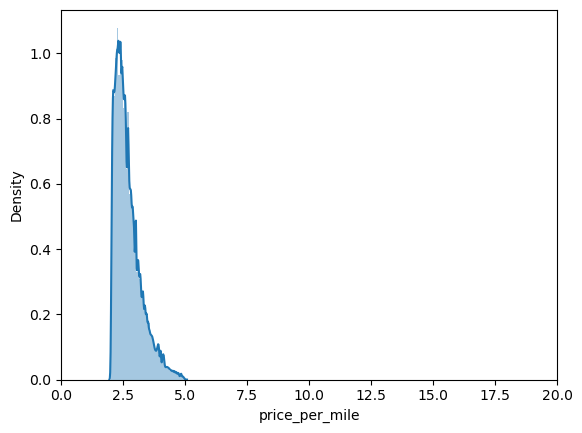

In [56]:
sns.distplot(df4["price_per_mile"])
plt.xlim(0,20)

plt.show()



In [57]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0          VTS  2009-01-04 02:52:00   2009-01-04 03:02:00                1   
3          DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5          DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
8          CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
11         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   

    Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
0            2.63 -73.991957  40.721567 -73.993803  40.695922         CASH   
3            5.00 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5            1.20 -73.989806  40.735006 -73.985021  40.724494         CASH   
8            1.60 -73.969690  40.749244 -73.990413  40.751082       Credit   
11           2.30 -74.006100  40.748432 -73.978437  40.762481         Cash   

    Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
0        8.9        0.5     0.00        0.0       9.40 0 days 00:10:00   
3       14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5        6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   
8        8.7        0.0     1.30        0.0      10.00 0 days 00:11:19   
11       7.7        0.0     0.00        0.0       7.70 0 days 00:06:58   

    Trip_time_hours  Trip_velocity  price_per_mile  
0          0.166667      15.780000        2.243346  
3          0.350556      14.263074        2.380000  
5          0.126667       9.473684        2.583333  
8          0.188611       8.483063        3.562500  
11         0.116111      19.808612        2.043478

# -----------------------------------------------------------------------------

# Sprawdzenie czy dystans euklidesowy pomiędzy współrzędnymi jest jakkolwiek proporcjonalny do drogi podróży (uwzględniając pewne odchylenie wynikające, że nie poruszamy się ruchem prostoliniowym) 

In [58]:
Lat_diff = df4["End_Lat"]-df4["Start_Lat"]
Lon_diff = df4["End_Lon"]-df4["Start_Lon"]
df4["Trip_dist_in_degrees"] = np.sqrt(np.power(Lat_diff,2)+np.power(Lon_diff,2))

# Nowy Jork leży na szerokości geograficznej około 40,7°N. Długość jednego stopnia długości geograficznej na tej szerokości wynosi około 85 km.

<Axes: xlabel='Trip_Distance', ylabel='Trip_dist_in_degrees'>

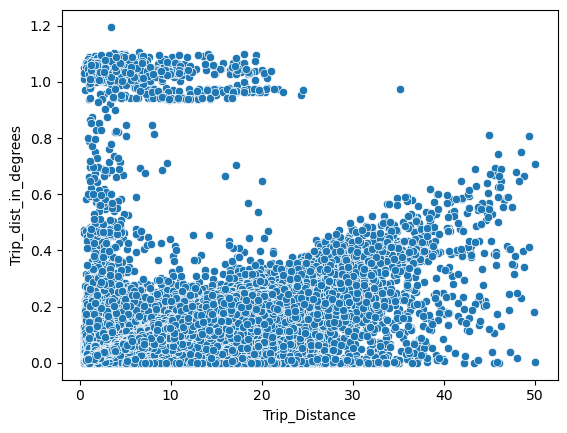

In [59]:
sns.scatterplot(x=df4["Trip_Distance"],y=df4["Trip_dist_in_degrees"])

In [60]:
def miles_to_latitude_degrees(miles, reference_lat=40.7128):
    start_point = (reference_lat, -74.0060)  
    end_point = geodesic(miles=miles).destination(start_point, bearing=0)
    return abs(end_point.latitude - start_point[0])
miles = 1
latitude_degrees = miles_to_latitude_degrees(miles)
print(f"{miles} mil = {latitude_degrees:.4f} stopień szerokości geograficznej")

1 mil = 0.0145 stopień szerokości geograficznej


In [61]:
df4["Trip_dist_miles_converted_degrees"] = df4["Trip_Distance"] * latitude_degrees

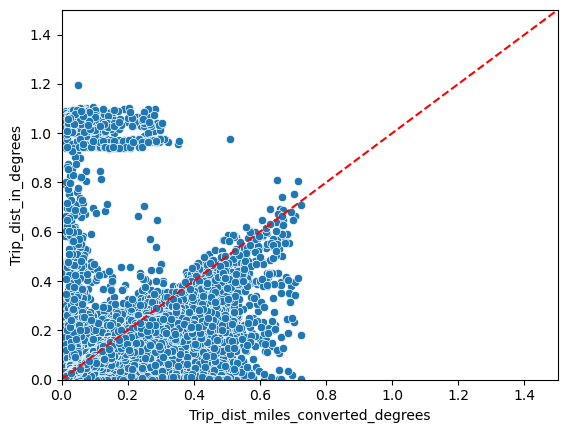

In [62]:
plt.xlim(0,1.5)
plt.ylim(0,1.5)
sns.scatterplot(x=df4["Trip_dist_miles_converted_degrees"],y=df4["Trip_dist_in_degrees"])
x_vals = np.linspace(0, 2, 100) 
plt.plot(x_vals, x_vals, linestyle="dashed", color="red", label="Linia 45°")
plt.show()

In [63]:
df4["diff_dist_degrees_converted"]  = df4["Trip_dist_in_degrees"] - df4["Trip_dist_miles_converted_degrees"]

df4[abs(df4["diff_dist_degrees_converted"])<0.1]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
0                VTS  2009-01-04 02:52:00   2009-01-04 03:02:00   
3                DDS  2009-01-01 20:52:58   2009-01-01 21:14:00   
5                DDS  2009-01-16 22:35:59   2009-01-16 22:43:35   
8                CMT  2009-01-05 16:29:02   2009-01-05 16:40:21   
11               CMT  2009-01-05 06:21:43   2009-01-05 06:28:41   
...              ...                  ...                   ...   
14092407         CMT  2009-01-23 14:44:39   2009-01-23 14:51:07   
14092408         VTS  2009-01-27 14:36:00   2009-01-27 14:46:00   
14092409         VTS  2009-01-27 13:56:00   2009-01-27 14:02:00   
14092410         CMT  2009-01-23 08:39:44   2009-01-23 09:02:15   
14092411         VTS  2009-01-24 23:05:00   2009-01-24 23:15:00   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
0                       1           2.63 -73.991957  40.721567 -73.993803   
3                       1           5.00 -73.974267  40.790955 -73.996558   
5                       2           1.20 -73.989806  40.735006 -73.985021   
8                       1           1.60 -73.969690  40.749244 -73.990413   
11                      1           2.30 -74.006100  40.748432 -73.978437   
...                   ...            ...        ...        ...        ...   
14092407                2           0.70 -73.982405  40.775247 -73.978472   
14092408                5           0.89 -73.982013  40.743330 -73.994328   
14092409                1           1.94 -73.972788  40.761988 -73.951477   
14092410                1           3.80 -73.977467  40.751861 -74.009913   
14092411                3           3.85 -73.981295  40.753000 -73.949453   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
0         40.695922         CASH       8.9        0.5     0.00        0.0   
3         40.731849       CREDIT      14.9        0.5     3.05        0.0   
5         40.724494         CASH       6.1        0.5     0.00        0.0   
8         40.751082       Credit       8.7        0.0     1.30        0.0   
11        40.762481         Cash       7.7        0.0     0.00        0.0   
...             ...          ...       ...        ...      ...        ...   
14092407  40.782864       Credit       5.3        0.0     1.10        0.0   
14092408  40.750130         CASH       6.5        0.0     0.00        0.0   
14092409  40.778217       Credit       8.1        0.0     1.90        0.0   
14092410  40.713470         Cash      14.5        0.0     0.00        0.0   
14092411  40.779520         CASH      10.9        0.5     0.00        0.0   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  \
0              9.40 0 days 00:10:00         0.166667      15.780000   
3             18.45 0 days 00:21:02         0.350556      14.263074   
5              6.60 0 days 00:07:36         0.126667       9.473684   
8             10.00 0 days 00:11:19         0.188611       8.483063   
11             7.70 0 days 00:06:58         0.116111      19.808612   
...             ...             ...              ...            ...   
14092407       6.40 0 days 00:06:28         0.107778       6.494845   
14092408       6.50 0 days 00:10:00         0.166667       5.340000   
14092409      10.00 0 days 00:06:00         0.100000      19.400000   
14092410      14.50 0 days 00:22:31         0.375278      10.125833   
14092411      11.40 0 days 00:10:00         0.166667      23.100000   

          price_per_mile  Trip_dist_in_degrees  \
0               2.243346              0.025711   
3               2.380000              0.063170   
5               2.583333              0.011550   
8               3.562500              0.020804   
11              2.043478              0.031026   
...                  ...                   ...   
14092407        3.285714              0.008572   
14092408        3.932584              0.014068   
14092409        2.628866              0.026787   
1

In [64]:
df4 = df4[abs(df4["diff_dist_degrees_converted"])<0.01]

In [65]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
3          DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5          DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
8          CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
11         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
12         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

    Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
3             5.0 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5             1.2 -73.989806  40.735006 -73.985021  40.724494         CASH   
8             1.6 -73.969690  40.749244 -73.990413  40.751082       Credit   
11            2.3 -74.006100  40.748432 -73.978437  40.762481         Cash   
12            2.1 -73.983339  40.744782 -73.981160  40.720835         CASH   

    Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
3       14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5        6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   
8        8.7        0.0     1.30        0.0      10.00 0 days 00:11:19   
11       7.7        0.0     0.00        0.0       7.70 0 days 00:06:58   
12       7.3        0.0     0.00        0.0       7.30 0 days 00:08:41   

    Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
3          0.350556      14.263074        2.380000              0.063170   
5          0.126667       9.473684        2.583333              0.011550   
8          0.188611       8.483063        3.562500              0.020804   
11         0.116111      19.808612        2.043478              0.031026   
12         0.144722      14.510557        2.047619              0.024046   

    Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  
3                            0.072461                    -0.009292  
5                            0.017391                    -0.005841  
8                            0.023188                    -0.002383  
11                           0.033332                    -0.002306  
12                           0.030434                    -0.006388

# -----------------------------------------------------------------------------

# Sprawdzenie czy ceny sumują się do wartości całkowitej:

In [66]:
df4['is_valid_total'] = (
    (df4['Fare_Amt'] + df4['surcharge'] + df4['Tip_Amt'] + df4['Tolls_Amt']).round(2) == df4['Total_Amt'].round(2)).astype(int)


In [67]:
df4[df4["is_valid_total"]==0]

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  \
404287           CMT  2009-01-31 12:36:06   2009-01-31 12:44:23   
600205           CMT  2009-01-30 17:56:34   2009-01-30 18:03:08   
1277499          DDS  2009-01-13 21:35:04   2009-01-13 21:59:09   
1602193          VTS  2009-01-15 12:43:00   2009-01-15 12:54:00   
1994070          CMT  2009-01-29 15:33:56   2009-01-29 16:04:13   
...              ...                  ...                   ...   
13149420         CMT  2009-01-04 18:15:55   2009-01-04 19:09:39   
13483850         VTS  2009-01-07 09:49:00   2009-01-07 09:58:00   
13583114         VTS  2009-01-06 16:53:00   2009-01-06 17:00:00   
13918238         CMT  2009-01-24 00:09:03   2009-01-24 00:28:19   
13961315         CMT  2009-01-06 10:48:34   2009-01-06 11:14:53   

          Passenger_Count  Trip_Distance  Start_Lon  Start_Lat    End_Lon  \
404287                  1           0.70 -73.976374  40.788580 -73.968194   
600205                  1           1.10 -73.959652  40.777092 -73.967682   
1277499                 1           3.40 -73.998050  40.725786 -73.975759   
1602193                 5           1.01 -73.981335  40.780895 -73.980733   
1994070                 1          13.20 -73.995415  40.733528 -74.182955   
...                   ...            ...        ...        ...        ...   
13149420                2           5.50 -73.943579  40.796022 -74.001504   
13483850                5           1.23 -73.968645  40.763157 -73.959870   
13583114                1           1.05 -73.964553  40.756448 -73.961228   
13918238                1           6.00 -73.993729  40.741784 -73.944882   
13961315                1           3.00 -73.986982  40.753651 -73.987495   

            End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
404287    40.791925         Cash       4.5        0.0     0.00        0.0   
600205    40.763657         Cash       6.7        0.0     0.00        0.0   
1277499   40.765393         CASH      13.7        0.5     0.00        0.0   
1602193   40.772328         CASH       5.7        0.0     0.00        0.0   
1994070   40.687935       Credit      60.9        0.0     0.00        0.0   
...             ...          ...       ...        ...      ...        ...   
13149420  40.744148         Cash      25.7        0.0     0.00        0.0   
13483850  40.769658       Credit       6.9        0.0     0.00        0.0   
13583114  40.766748       Credit       5.7        1.0     1.34        0.0   
13918238  40.813574         Cash      17.8        0.0     0.00        0.0   
13961315  40.719972         Cash      14.5        0.0     0.00        0.0   

          Total_Amt       Trip_time  Trip_time_hours  Trip_velocity  \
404287        28.94 0 days 00:08:17         0.138056       5.070423   
600205        47.84 0 days 00:06:34         0.109444      10.050761   
1277499      114.20 0 days 00:24:05         0.401389       8.470588   
1602193       85.70 0 days 00:11:00         0.183333       5.509091   
1994070       88.40 0 days 00:30:17         0.504722      26.152999   
...             ...             ...              ...            ...   
13149420      75.51 0 days 00:53:44         0.895556       6.141439   
13483850      51.90 0 days 00:09:00         0.150000       8.200000   
13583114      53.04 0 days 00:07:00         0.116667       9.000000   
13918238     102.24 0 days 00:19:16         0.321111      18.685121   
13961315      47.71 0 days 00:26:19         0.438611       6.839772   

          price_per_mile  Trip_dist_in_degrees  \
404287          2.142857              0.008838   
600205          3.363636              0.015652   
1277499         3.147059              0.045449   
1602193         2.673267              0.008588   
1994070         4.386364              0.193003   
...                  ...                   ...   
13149420        4.127273              0.077757   
13483850        3.170732              0.010921   
13583114        2.571429              0.010823   
1

In [68]:
df4 = df4[df4["is_valid_total"]==1]

In [69]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
3          DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5          DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
8          CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
11         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
12         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

    Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
3             5.0 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5             1.2 -73.989806  40.735006 -73.985021  40.724494         CASH   
8             1.6 -73.969690  40.749244 -73.990413  40.751082       Credit   
11            2.3 -74.006100  40.748432 -73.978437  40.762481         Cash   
12            2.1 -73.983339  40.744782 -73.981160  40.720835         CASH   

    Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
3       14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5        6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   
8        8.7        0.0     1.30        0.0      10.00 0 days 00:11:19   
11       7.7        0.0     0.00        0.0       7.70 0 days 00:06:58   
12       7.3        0.0     0.00        0.0       7.30 0 days 00:08:41   

    Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
3          0.350556      14.263074        2.380000              0.063170   
5          0.126667       9.473684        2.583333              0.011550   
8          0.188611       8.483063        3.562500              0.020804   
11         0.116111      19.808612        2.043478              0.031026   
12         0.144722      14.510557        2.047619              0.024046   

    Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  \
3                            0.072461                    -0.009292   
5                            0.017391                    -0.005841   
8                            0.023188                    -0.002383   
11                           0.033332                    -0.002306   
12                           0.030434                    -0.006388   

    is_valid_total  
3                1  
5                1  
8                1  
11               1  
12               1

# -----------------------------------------------------------------------------

# Sprawdzenie czy są jakieś napiwki wpisane na karcie, jeżeli płatność była gotówką:

In [70]:
df4[(df4["Payment_Type"]=="CASH") & df4["Tip_Amt"] != 0]
# Dane są spójne logicznie w tym przypadku

Empty DataFrame
Columns: [vendor_name, Trip_Pickup_DateTime, Trip_Dropoff_DateTime, Passenger_Count, Trip_Distance, Start_Lon, Start_Lat, End_Lon, End_Lat, Payment_Type, Fare_Amt, surcharge, Tip_Amt, Tolls_Amt, Total_Amt, Trip_time, Trip_time_hours, Trip_velocity, price_per_mile, Trip_dist_in_degrees, Trip_dist_miles_converted_degrees, diff_dist_degrees_converted, is_valid_total]
Index: []

# -----------------------------------------------------------------------------

# Sprawdzenie czy wartości współrzędnych początkowych znajdują się w obszarze Nowego Yorku: m.in. czy nie znajdują się na wodzie

<Axes: xlabel='Start_Lon', ylabel='Start_Lat'>

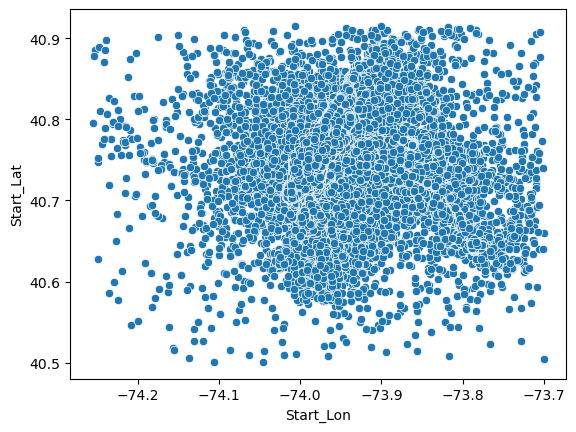

In [71]:
sns.scatterplot(x=df4["Start_Lon"],y=df4["Start_Lat"])

In [72]:
nyc_boroughs = gpd.read_file("new-york-city-boroughs.geojson")
df4['geometry'] = [
    Point(xy) for xy in zip(df4['Start_Lon'], df4['Start_Lat'])
]
points_gdf = gpd.GeoDataFrame(df4, geometry='geometry', crs="EPSG:4326")
nyc_boroughs = nyc_boroughs.to_crs("EPSG:4326")

joined_gdf = gpd.sjoin(points_gdf, nyc_boroughs, how="left", predicate="within")
joined_gdf['inside_NYC'] = ~joined_gdf['index_right'].isnull()
inside_df = joined_gdf[joined_gdf['inside_NYC'] == True]
inside_df = inside_df.drop(columns=['index_right', 'geometry', 'inside_NYC'])
inside_df.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
3          DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5          DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
8          CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
11         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
12         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

    Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
3             5.0 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5             1.2 -73.989806  40.735006 -73.985021  40.724494         CASH   
8             1.6 -73.969690  40.749244 -73.990413  40.751082       Credit   
11            2.3 -74.006100  40.748432 -73.978437  40.762481         Cash   
12            2.1 -73.983339  40.744782 -73.981160  40.720835         CASH   

    Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
3       14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5        6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   
8        8.7        0.0     1.30        0.0      10.00 0 days 00:11:19   
11       7.7        0.0     0.00        0.0       7.70 0 days 00:06:58   
12       7.3        0.0     0.00        0.0       7.30 0 days 00:08:41   

    Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
3          0.350556      14.263074        2.380000              0.063170   
5          0.126667       9.473684        2.583333              0.011550   
8          0.188611       8.483063        3.562500              0.020804   
11         0.116111      19.808612        2.043478              0.031026   
12         0.144722      14.510557        2.047619              0.024046   

    Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  \
3                            0.072461                    -0.009292   
5                            0.017391                    -0.005841   
8                            0.023188                    -0.002383   
11                           0.033332                    -0.002306   
12                           0.030434                    -0.006388   

    is_valid_total       name  cartodb_id                       created_at  \
3                1  Manhattan         4.0 2013-03-09 02:42:03.692000+00:00   
5                1  Manhattan         4.0 2013-03-09 02:42:03.692000+00:00   
8                1  Manhattan         4.0 2013-03-09 02:42:03.692000+00:00   
11               1  Manhattan         4.0 2013-03-09 02:42:03.692000+00:00   
12               1  Manhattan         4.0 2013-03-09 02:42:03.692000+00:00   

                         updated_at  
3  2013-03-09 02:42:03.989000+00:00  
5  2013-03-09 02:42:03.989000+00:00  
8  2013-03-09 02:42:03.989000+00:00  
11 2013-03-09 02:42:03.989000+00:00  
12 2013-03-09 02:42:03.989000+00:00

In [73]:
df4 = inside_df

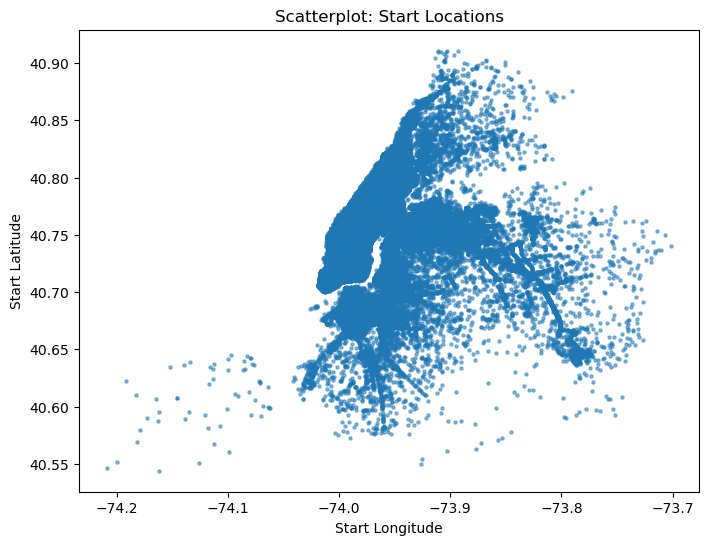

In [74]:
plt.figure(figsize=(8,6))
plt.scatter(df4['Start_Lon'], df4['Start_Lat'], s=5, alpha=0.5)
plt.xlabel('Start Longitude')
plt.ylabel('Start Latitude')
plt.title('Scatterplot: Start Locations')
plt.show()

# -----------------------------------------------------------------------------

#  Sprawdzenie czy wartości współrzędnych końcowych znajdują się w obszarze Nowego Yorku (nie muszą, lecz lepiej wyeliminować wiersze które kończą się w wodzie i stracić niektóre te które znajdują się poza poza obszarem Nowego Yorku)

<Axes: xlabel='End_Lon', ylabel='End_Lat'>

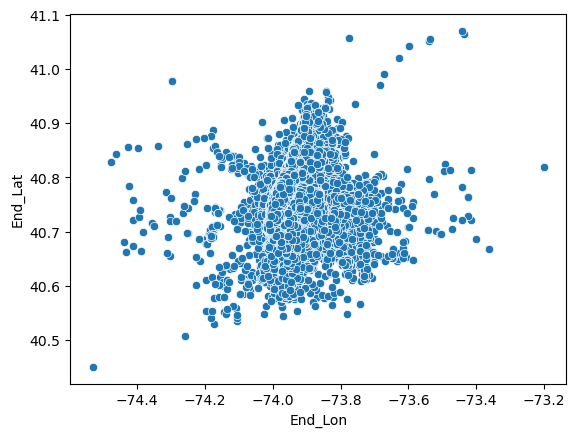

In [75]:
sns.scatterplot(x=df4["End_Lon"],y=df4["End_Lat"])

In [76]:

nyc_boroughs = gpd.read_file("new-york-city-boroughs.geojson")
df4['geometry'] = [
    Point(xy) for xy in zip(df4['End_Lon'], df4['End_Lat'])
]
points_gdf = gpd.GeoDataFrame(df4, geometry='geometry', crs="EPSG:4326")
nyc_boroughs = nyc_boroughs.to_crs("EPSG:4326")

joined_gdf = gpd.sjoin(points_gdf, nyc_boroughs, how="left", predicate="within")
joined_gdf['inside_NYC'] = ~joined_gdf['index_right'].isnull()
inside_df = joined_gdf[joined_gdf['inside_NYC'] == True]
inside_df = inside_df.drop(columns=['index_right', 'geometry', 'inside_NYC'])
inside_df.head()


vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
3          DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5          DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
8          CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
11         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
12         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

    Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
3             5.0 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5             1.2 -73.989806  40.735006 -73.985021  40.724494         CASH   
8             1.6 -73.969690  40.749244 -73.990413  40.751082       Credit   
11            2.3 -74.006100  40.748432 -73.978437  40.762481         Cash   
12            2.1 -73.983339  40.744782 -73.981160  40.720835         CASH   

    Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
3       14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5        6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   
8        8.7        0.0     1.30        0.0      10.00 0 days 00:11:19   
11       7.7        0.0     0.00        0.0       7.70 0 days 00:06:58   
12       7.3        0.0     0.00        0.0       7.30 0 days 00:08:41   

    Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
3          0.350556      14.263074        2.380000              0.063170   
5          0.126667       9.473684        2.583333              0.011550   
8          0.188611       8.483063        3.562500              0.020804   
11         0.116111      19.808612        2.043478              0.031026   
12         0.144722      14.510557        2.047619              0.024046   

    Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  \
3                            0.072461                    -0.009292   
5                            0.017391                    -0.005841   
8                            0.023188                    -0.002383   
11                           0.033332                    -0.002306   
12                           0.030434                    -0.006388   

    is_valid_total  name_left  cartodb_id_left  \
3                1  Manhattan              4.0   
5                1  Manhattan              4.0   
8                1  Manhattan              4.0   
11               1  Manhattan              4.0   
12               1  Manhattan              4.0   

                    created_at_left                  updated_at_left  \
3  2013-03-09 02:42:03.692000+00:00 2013-03-09 02:42:03.989000+00:00   
5  2013-03-09 02:42:03.692000+00:00 2013-03-09 02:42:03.989000+00:00   
8  2013-03-09 02:42:03.692000+00:00 2013-03-09 02:42:03.989000+00:00   
11 2013-03-09 02:42:03.692000+00:00 2013-03-09 02:42:03.989000+00:00   
12 2013-03-09 02:42:03.692000+00:00 2013-03-09 02:42:03.989000+00:00   

   name_right  cartodb_id_right                 created_at_right  \
3   Manhattan               4.0 2013-03-09 02:42:03.692000+00:00   
5   Manhattan               4.0 2013-03-09 02:42:03.692000+00:00   
8   Manhattan               4.0 2013-03-09 02:42:03.692000+00:00   
11  Manhattan               4.0 2013-03-09 02:42:03.692000+00:00   
12  Manhattan               4.0 2013-03-09 02:42:03.692000+00:00   

                   updated_at_right  
3  2013-03-09 02:42:03.989000+00:00  
5  2013-03-09 02:42:03.989000+00:00  
8  2013-03-09 02:42:03.989000+00:00  
11 2013-03-09 02:42:03.989000+00:00  
12 2013-03-09 02:42:03.989000+00:00

In [77]:
df4 = inside_df
df4.columns

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat', 'End_Lon',
       'End_Lat', 'Payment_Type', 'Fare_Amt', 'surcharge', 'Tip_Amt',
       'Tolls_Amt', 'Total_Amt', 'Trip_time', 'Trip_time_hours',
       'Trip_velocity', 'price_per_mile', 'Trip_dist_in_degrees',
       'Trip_dist_miles_converted_degrees', 'diff_dist_degrees_converted',
       'is_valid_total', 'name_left', 'cartodb_id_left', 'created_at_left',
       'updated_at_left', 'name_right', 'cartodb_id_right', 'created_at_right',
       'updated_at_right'],
      dtype='object')

In [78]:
df4.drop(columns=['updated_at_right',"cartodb_id_left","created_at_left","updated_at_left","name_right","cartodb_id_right","created_at_right"],axis=1,inplace=True)

In [79]:
df4.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
3          DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
5          DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
8          CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
11         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
12         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

    Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
3             5.0 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
5             1.2 -73.989806  40.735006 -73.985021  40.724494         CASH   
8             1.6 -73.969690  40.749244 -73.990413  40.751082       Credit   
11            2.3 -74.006100  40.748432 -73.978437  40.762481         Cash   
12            2.1 -73.983339  40.744782 -73.981160  40.720835         CASH   

    Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt       Trip_time  \
3       14.9        0.5     3.05        0.0      18.45 0 days 00:21:02   
5        6.1        0.5     0.00        0.0       6.60 0 days 00:07:36   
8        8.7        0.0     1.30        0.0      10.00 0 days 00:11:19   
11       7.7        0.0     0.00        0.0       7.70 0 days 00:06:58   
12       7.3        0.0     0.00        0.0       7.30 0 days 00:08:41   

    Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
3          0.350556      14.263074        2.380000              0.063170   
5          0.126667       9.473684        2.583333              0.011550   
8          0.188611       8.483063        3.562500              0.020804   
11         0.116111      19.808612        2.043478              0.031026   
12         0.144722      14.510557        2.047619              0.024046   

    Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  \
3                            0.072461                    -0.009292   
5                            0.017391                    -0.005841   
8                            0.023188                    -0.002383   
11                           0.033332                    -0.002306   
12                           0.030434                    -0.006388   

    is_valid_total  name_left  
3                1  Manhattan  
5                1  Manhattan  
8                1  Manhattan  
11               1  Manhattan  
12               1  Manhattan

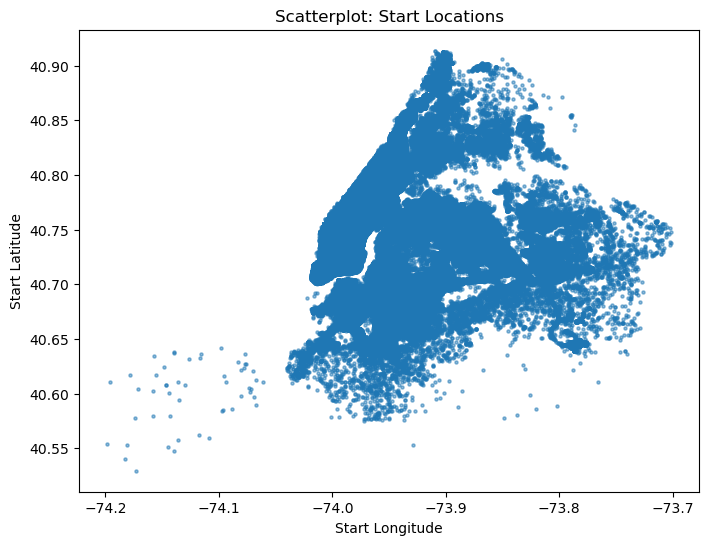

In [80]:
plt.figure(figsize=(8,6))
plt.scatter(df4['End_Lon'], df4['End_Lat'], s=5, alpha=0.5)
plt.xlabel('Start Longitude')
plt.ylabel('Start Latitude')
plt.title('Scatterplot: Start Locations')
plt.show()

In [83]:
df4.to_csv("dane_obrobione_taxi.csv")
df4.count()

Unnamed: 0                           7109684
vendor_name                          7109684
Trip_Pickup_DateTime                 7109684
Trip_Dropoff_DateTime                7109684
Passenger_Count                      7109684
Trip_Distance                        7109684
Start_Lon                            7109684
Start_Lat                            7109684
End_Lon                              7109684
End_Lat                              7109684
Payment_Type                         7109684
Fare_Amt                             7109684
surcharge                            7109684
Tip_Amt                              7109684
Tolls_Amt                            7109684
Total_Amt                            7109684
Day                                  7109684
Pickup_Hour                          7109684
Pickup_Minute                        7109684
Trip_time                            7109684
Trip_time_hours                      7109684
Trip_velocity                        7109684
price_per_

# -----------------------------------------------------------------------------

# Wczytanie danych obrobionych z pliku csv:

In [84]:
df4 = pd.read_csv("dane_obrobione_taxi.csv")
df4['Trip_Pickup_DateTime'] = pd.to_datetime(df4['Trip_Pickup_DateTime'], errors='coerce')
df4['Trip_Dropoff_DateTime'] = pd.to_datetime(df4['Trip_Dropoff_DateTime'], errors='coerce')
print(df4.dtypes)

Unnamed: 0.1                                  int64
Unnamed: 0                                    int64
vendor_name                                  object
Trip_Pickup_DateTime                 datetime64[ns]
Trip_Dropoff_DateTime                datetime64[ns]
Passenger_Count                               int64
Trip_Distance                               float64
Start_Lon                                   float64
Start_Lat                                   float64
End_Lon                                     float64
End_Lat                                     float64
Payment_Type                                 object
Fare_Amt                                    float64
surcharge                                   float64
Tip_Amt                                     float64
Tolls_Amt                                   float64
Total_Amt                                   float64
Day                                          object
Pickup_Hour                                   int64
Pickup_Minut

In [85]:
df4.head()

Unnamed: 0.1  Unnamed: 0 vendor_name Trip_Pickup_DateTime  \
0             0           3         DDS  2009-01-01 20:52:58   
1             1           5         DDS  2009-01-16 22:35:59   
2             2           8         CMT  2009-01-05 16:29:02   
3             3          11         CMT  2009-01-05 06:21:43   
4             4          12         DDS  2009-01-20 13:44:02   

  Trip_Dropoff_DateTime  Passenger_Count  Trip_Distance  Start_Lon  Start_Lat  \
0   2009-01-01 21:14:00                1            5.0 -73.974267  40.790955   
1   2009-01-16 22:43:35                2            1.2 -73.989806  40.735006   
2   2009-01-05 16:40:21                1            1.6 -73.969690  40.749244   
3   2009-01-05 06:28:41                1            2.3 -74.006100  40.748432   
4   2009-01-20 13:52:43                2            2.1 -73.983339  40.744782   

     End_Lon    End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
0 -73.996558  40.731849       CREDIT      14.9        0.5     3.05        0.0   
1 -73.985021  40.724494         CASH       6.1        0.5     0.00        0.0   
2 -73.990413  40.751082       Credit       8.7        0.0     1.30        0.0   
3 -73.978437  40.762481         Cash       7.7        0.0     0.00        0.0   
4 -73.981160  40.720835         CASH       7.3        0.0     0.00        0.0   

   Total_Amt       Day  Pickup_Hour  Pickup_Minute        Trip_time  \
0      18.45  Thursday           20             52  0 days 00:21:02   
1       6.60    Friday           22             35  0 days 00:07:36   
2      10.00    Monday           16             29  0 days 00:11:19   
3       7.70    Monday            6             21  0 days 00:06:58   
4       7.30   Tuesday           13             44  0 days 00:08:41   

   Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
0         0.350556      14.263074        2.380000              0.063170   
1         0.126667       9.473684        2.583333              0.011550   
2         0.188611       8.483063        3.562500              0.020804   
3         0.116111      19.808612        2.043478              0.031026   
4         0.144722      14.510557        2.047619              0.024046   

   Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  \
0                           0.072461                    -0.009292   
1                           0.017391                    -0.005841   
2                           0.023188                    -0.002383   
3                           0.033332                    -0.002306   
4                           0.030434                    -0.006388   

   is_valid_total                              geometry  name_left  is_in_nyc  \
0               1  POINT (-73.99655799999998 40.731849)  Manhattan       True   
1               1          POINT (-73.985021 40.724494)  Manhattan       True   
2               1          POINT (-73.990413 40.751082)  Manhattan       True   
3               1          POINT (-73.978437 40.762481)  Manhattan       True   
4               1           POINT (-73.98116 40.720835)  Manhattan       True   

  name_right  
0  Manhattan  
1  Manhattan  
2  Manhattan  
3  Manhattan  
4  Manhattan

In [86]:
df4['day_num'] = df4['Trip_Pickup_DateTime'].dt.weekday
df4["pickup_hour_of_the_week"] = df4['day_num'] * 24 + df4['Trip_Pickup_DateTime'].dt.hour

# Wstępne wizualizacje danych: 

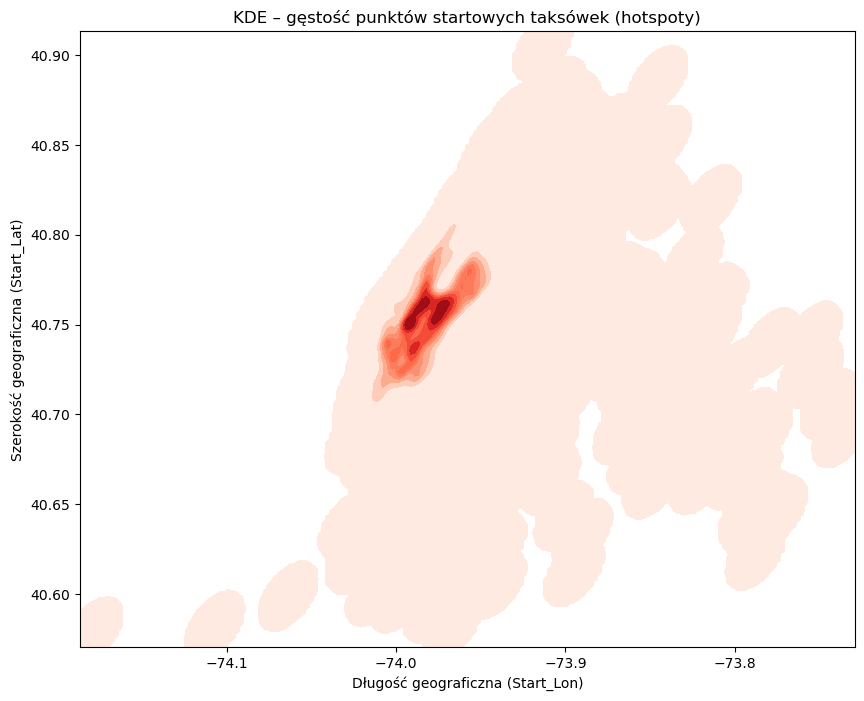

In [87]:
df_sample = df4.sample(n=200_000, random_state=42)

plt.figure(figsize=(10, 8))

sns.kdeplot(
    data=df_sample,
    x="Start_Lon",
    y="Start_Lat",
    cmap="Reds", 
    fill=True,   
    levels=10,   
    thresh=0,    
    alpha=1     
)

plt.title("KDE – gęstość punktów startowych taksówek (hotspoty)")
plt.xlabel("Długość geograficzna (Start_Lon)")
plt.ylabel("Szerokość geograficzna (Start_Lat)")
plt.show()

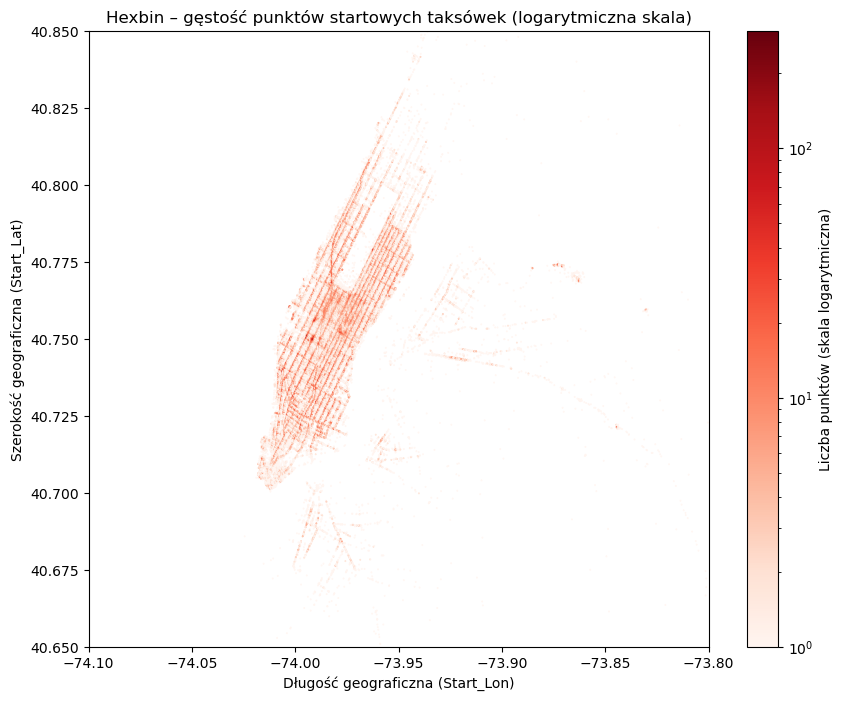

In [88]:

plt.figure(figsize=(10, 8))

plt.hexbin(
    x=df_sample['Start_Lon'],
    y=df_sample['Start_Lat'],
    gridsize=2000,             
    cmap='Reds',               
    norm=mcolors.LogNorm()     
)

cb = plt.colorbar()
cb.set_label('Liczba punktów (skala logarytmiczna)')

plt.xlim([-74.1, -73.8])
plt.ylim([40.65, 40.85])

plt.title("Hexbin – gęstość punktów startowych taksówek (logarytmiczna skala)")
plt.xlabel("Długość geograficzna (Start_Lon)")
plt.ylabel("Szerokość geograficzna (Start_Lat)")
plt.show()


In [89]:
df4["name_left"].value_counts()

name_left
Manhattan        6945705
Queens             92883
Brooklyn           69006
Bronx               2049
Staten Island         41
Name: count, dtype: int64

In [90]:
df4.head()

Unnamed: 0.1  Unnamed: 0 vendor_name Trip_Pickup_DateTime  \
0             0           3         DDS  2009-01-01 20:52:58   
1             1           5         DDS  2009-01-16 22:35:59   
2             2           8         CMT  2009-01-05 16:29:02   
3             3          11         CMT  2009-01-05 06:21:43   
4             4          12         DDS  2009-01-20 13:44:02   

  Trip_Dropoff_DateTime  Passenger_Count  Trip_Distance  Start_Lon  Start_Lat  \
0   2009-01-01 21:14:00                1            5.0 -73.974267  40.790955   
1   2009-01-16 22:43:35                2            1.2 -73.989806  40.735006   
2   2009-01-05 16:40:21                1            1.6 -73.969690  40.749244   
3   2009-01-05 06:28:41                1            2.3 -74.006100  40.748432   
4   2009-01-20 13:52:43                2            2.1 -73.983339  40.744782   

     End_Lon    End_Lat Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
0 -73.996558  40.731849       CREDIT      14.9        0.5     3.05        0.0   
1 -73.985021  40.724494         CASH       6.1        0.5     0.00        0.0   
2 -73.990413  40.751082       Credit       8.7        0.0     1.30        0.0   
3 -73.978437  40.762481         Cash       7.7        0.0     0.00        0.0   
4 -73.981160  40.720835         CASH       7.3        0.0     0.00        0.0   

   Total_Amt       Day  Pickup_Hour  Pickup_Minute        Trip_time  \
0      18.45  Thursday           20             52  0 days 00:21:02   
1       6.60    Friday           22             35  0 days 00:07:36   
2      10.00    Monday           16             29  0 days 00:11:19   
3       7.70    Monday            6             21  0 days 00:06:58   
4       7.30   Tuesday           13             44  0 days 00:08:41   

   Trip_time_hours  Trip_velocity  price_per_mile  Trip_dist_in_degrees  \
0         0.350556      14.263074        2.380000              0.063170   
1         0.126667       9.473684        2.583333              0.011550   
2         0.188611       8.483063        3.562500              0.020804   
3         0.116111      19.808612        2.043478              0.031026   
4         0.144722      14.510557        2.047619              0.024046   

   Trip_dist_miles_converted_degrees  diff_dist_degrees_converted  \
0                           0.072461                    -0.009292   
1                           0.017391                    -0.005841   
2                           0.023188                    -0.002383   
3                           0.033332                    -0.002306   
4                           0.030434                    -0.006388   

   is_valid_total                              geometry  name_left  is_in_nyc  \
0               1  POINT (-73.99655799999998 40.731849)  Manhattan       True   
1               1          POINT (-73.985021 40.724494)  Manhattan       True   
2               1          POINT (-73.990413 40.751082)  Manhattan       True   
3               1          POINT (-73.978437 40.762481)  Manhattan       True   
4               1           POINT (-73.98116 40.720835)  Manhattan       True   

  name_right  day_num  pickup_hour_of_the_week  
0  Manhattan        3                       92  
1  Manhattan        4                      118  
2  Manhattan        0                       16  
3  Manhattan        0                        6  
4  Manhattan        1                       37

# Wniosek: Powinniśmy skupić się przede wszystkim na Manhatanie, gdyż nieproporcjonalna ilość wszystkich przejazdów tam rozpoczyna swój bieg 

# -----------------------------------------------------------------------------

# Problem 1: Optymalny kierunek ruchu dla taksówkarza, który ma status "wolny" i chce maksymalizować szansę zdobycia jakiegoś zlecenia


In [15]:
"""
df4 = pd.read_csv("dane_obrobione_taxi.csv")
df4['Trip_Pickup_DateTime'] = pd.to_datetime(df4['Trip_Pickup_DateTime'], errors='coerce')
df4['Trip_Dropoff_DateTime'] = pd.to_datetime(df4['Trip_Dropoff_DateTime'], errors='coerce')
df4.drop("Unnamed: 0", axis=1, inplace=True)
day_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

df4['day_num'] = df4['Day'].map(day_map)
df4["pickup_hour_of_the_week"] = df4['day_num'] * 24 + df4['Pickup_Hour']
df = df4
"""

In [91]:
df = df4
df = df[['Trip_Pickup_DateTime', 'Start_Lat', 'Start_Lon']]


df['day_of_week'] = df['Trip_Pickup_DateTime'].dt.dayofweek  
df['quarter_hour'] = df['Trip_Pickup_DateTime'].dt.hour * 4 + df['Trip_Pickup_DateTime'].dt.minute // 15


df['h3_cell'] = df.apply(lambda row: h3.latlng_to_cell(row['Start_Lat'], row['Start_Lon'], res=9), axis=1)


demand = df.groupby(['h3_cell', 'day_of_week', 'quarter_hour']).size().reset_index(name='trip_count')

demand['centroid_lat'] = demand['h3_cell'].apply(lambda h: h3.cell_to_latlng(h)[0])
demand['centroid_lon'] = demand['h3_cell'].apply(lambda h: h3.cell_to_latlng(h)[1])

C:\Users\marco\AppData\Local\Temp\ipykernel_2548\893145604.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['Trip_Pickup_DateTime'].dt.dayofweek
C:\Users\marco\AppData\Local\Temp\ipykernel_2548\893145604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter_hour'] = df['Trip_Pickup_DateTime'].dt.hour * 4 + df['Trip_Pickup_DateTime'].dt.minute // 15
C:\Users\marco\AppData\Local\Temp\ipykernel_2548\893145604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a co

# Algorytm dzieli dane da podzbiory o konktretnym dniu tygodnia i kwartale godzinowym(15min odstępie) tak by optymalizować czas obliczeniowy (pre-processing) i móc jak najszybciej wyznaczyć kierunek optymalnego ruchu dla kierowcy

# Algorytm wizualizuje gradient funkcji f(szerokość geograficzna) i f(długość geograficzna), gdzie f(x) to liczba zleceń przypisana do poszczególnego hexagonu geograficznego. Linii wyznacza kierunek najszybszego wzrostu funkcji liczby zleceń

In [92]:
app = Dash(__name__)
app.layout = html.Div([
    html.H3("Mapa popytu NYC Taxi"),
    dcc.Slider(
        id='day-slider', min=0, max=6, step=1, value=0,
        marks={i: day_name for i, day_name in enumerate(["Pon", "Wt", "Śr", "Czw", "Pt", "Sob", "Nd"])}
    ),
    dcc.Slider(
        id='quarter-slider', min=0, max=95, step=1, value=0,
        marks={0: "00:00", 20: "05:00", 40: "10:00", 60: "15:00", 80: "20:00"}
    ),
    dcc.Graph(id='demand-3d-graph', figure=go.Figure())
])

@app.callback(
    Output('demand-3d-graph', 'figure'),
    [Input('day-slider', 'value'), Input('quarter-slider', 'value')]
)
def update_graph(selected_day, selected_qtr):
    subset = demand[(demand['day_of_week'] == selected_day) & (demand['quarter_hour'] == selected_qtr)]

    fig = go.Figure(data=[
        go.Scatter3d(
            x=subset['centroid_lon'],
            y=subset['centroid_lat'],
            z=subset['trip_count'],
            mode='markers',
            marker=dict(
                size=4,
                color=subset['trip_count'],
                colorscale='turbo',
                cmin=0,
                cmax=demand['trip_count'].max(),
                colorbar=dict(
                    title="Liczba<br>kursów",
                    x=-0.1,
                    xanchor="left"
                ),
                opacity=0.8
            ),
            name="Popyt"
        )
    ])
    
    fig.update_layout(
        scene=dict(
            xaxis_title="Dł.geogr.",
            yaxis_title="Szer.geogr.",
            zaxis_title="Liczba kursów"
        ),
        title=f"Popyt na taksówki - Dzień {selected_day}, kwartał {selected_qtr}"
    )
    
    taxi_lon, taxi_lat = -73.8, 40.7
    
    if len(subset) >= 3:
        lon_vals = subset['centroid_lon'].values
        lat_vals = subset['centroid_lat'].values
        demand_vals = subset['trip_count'].values


        rbf = Rbf(lon_vals, lat_vals, demand_vals, function='multiquadric', smooth=5)


        epsilon = 1e-4
        D0 = rbf(taxi_lon, taxi_lat)
        D_lon_fwd = rbf(taxi_lon + epsilon, taxi_lat)
        D_lon_bwd = rbf(taxi_lon - epsilon, taxi_lat)
        D_lat_fwd = rbf(taxi_lon, taxi_lat + epsilon)
        D_lat_bwd = rbf(taxi_lon, taxi_lat - epsilon)

        dD_dlon = (D_lon_fwd - D_lon_bwd) / (2 * epsilon)
        dD_dlat = (D_lat_fwd - D_lat_bwd) / (2 * epsilon)


        grad_vec = np.array([dD_dlon, dD_dlat])
        if np.linalg.norm(grad_vec) != 0:
            grad_dir = grad_vec / np.linalg.norm(grad_vec)
        else:
            grad_dir = grad_vec


        arrow_length = 0.02
        end_lon = taxi_lon + grad_dir[0] * arrow_length
        end_lat = taxi_lat + grad_dir[1] * arrow_length


        fig.add_trace(go.Scatter3d(
            x=[taxi_lon, end_lon],
            y=[taxi_lat, end_lat],
            z=[0, 0],
            mode='lines',
            line=dict(color='red', width=6),
            name="Kierunek ruchu"
        ))
        

        fig.add_trace(go.Cone(
            x=[end_lon],
            y=[end_lat],
            z=[0],
            u=[grad_dir[0]],
            v=[grad_dir[1]],
            w=[0],
            sizemode="absolute",
            sizeref=0.01,  
            anchor="tip",
            showscale=False,
            colorscale=[[0, 'red'], [1, 'red']],
            name="Grot"
        ))
        

        fig.add_trace(go.Scatter3d(
            x=[taxi_lon],
            y=[taxi_lat],
            z=[0],
            mode='markers',
            marker=dict(size=3, color='blue'),
            name="Punkt startowy"
        ))
        fig.add_trace(go.Scatter3d(
            x=[end_lon],
            y=[end_lat],
            z=[0],
            mode='markers',
            marker=dict(size=3, color='green'),
            name="Punkt końcowy"
        ))
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

# -----------------------------------------------------------------------------

# Jak wygląda ta wizualizacja:

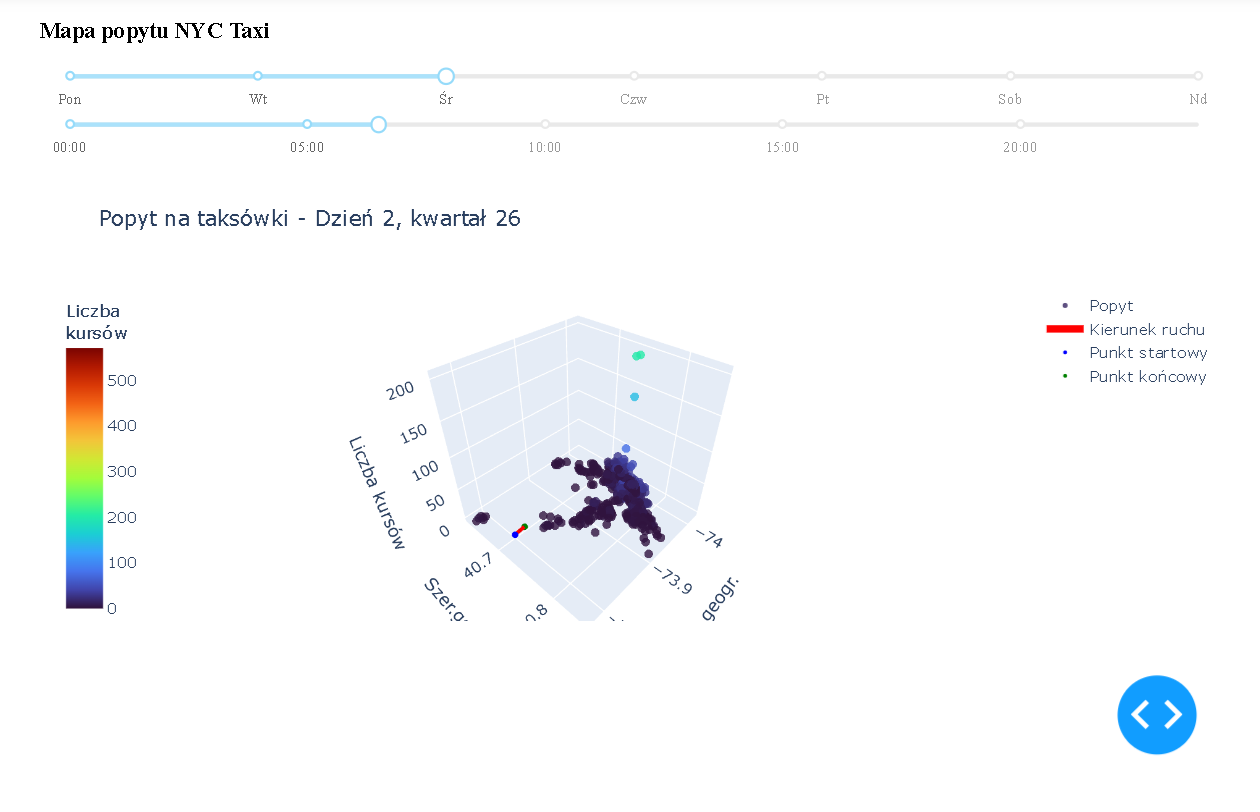

In [65]:
display(Image.open("optymalny_kierunek_ruchu.png"))

# -----------------------------------------------------------------------------

# Problem 2: Optymalna czasowo i geograficznie alokacja taksówek na Manhattanie w celu minimalizacji czasu oczekiwania

In [18]:
"""
df4 = pd.read_csv("dane_obrobione_taxi.csv")
df4['Trip_Pickup_DateTime'] = pd.to_datetime(df4['Trip_Pickup_DateTime'], errors='coerce')
df4['Trip_Dropoff_DateTime'] = pd.to_datetime(df4['Trip_Dropoff_DateTime'], errors='coerce')
df4.drop("Unnamed: 0", axis=1, inplace=True)
day_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

df4['day_num'] = df4['Day'].map(day_map)
df4["pickup_hour_of_the_week"] = df4['day_num'] * 24 + df4['Pickup_Hour']
df = df4
"""

In [93]:
df = df4

In [94]:
# W kierunku Północ-Południe 500m to około 0.0045 jednostek szerokości geograficznej, a około 0.0059 jednostek w kierunku 
# wschód-zachód
nyc_map = gpd.read_file("new-york-city-boroughs.geojson")
min_lon, min_lat, max_lon, max_lat = nyc_map.total_bounds
lat_step = 0.0045 
lon_step = 0.0059 
num_lat_cells = int(np.ceil((max_lat - min_lat) / lat_step))
num_lon_cells = int(np.ceil((max_lon - min_lon) / lon_step))
df.loc[:, 'lat_idx'] = np.floor((df['Start_Lat'] - min_lat) / lat_step).astype(int)
df.loc[:, 'lon_idx'] = np.floor((df['Start_Lon'] - min_lon) / lon_step).astype(int)
df.loc[:, 'lat_idx'] = df['lat_idx'].clip(lower=0, upper=num_lat_cells-1)
df.loc[:, 'lon_idx'] = df['lon_idx'].clip(lower=0, upper=num_lon_cells-1)
df.loc[:, 'Pickup_dt'] = pd.to_datetime(df['Trip_Pickup_DateTime'])
df.loc[:, 'weekday'] = df['Pickup_dt'].dt.weekday     
df.loc[:, 'quarter_idx'] = df['Pickup_dt'].dt.hour * 4 + df['Pickup_dt'].dt.minute // 15

# 2 analiza wykorzystuje algorytmy zachłanne w celu szukania optimum lokalnego (licząc, że jest to również optimum globalne), tak aby efektywnie czasowo i z możliwością szybkiej regulacji parametrów dnia,kwartału godzinowego (okresu 15 minutowego) oraz liczby Taxówek, optymalnie alokować liczbę taksówkarzy

In [95]:
demand = df.groupby(['weekday', 'quarter_idx', 'lat_idx', 'lon_idx']).size().reset_index(name='count')

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



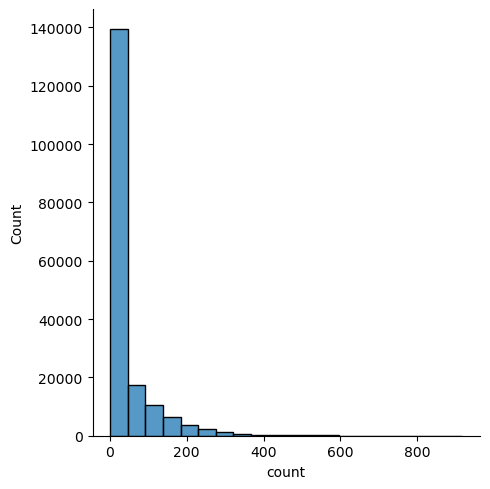

In [96]:
sns.displot(demand["count"],bins=20)

# Z racji dużego obciążenia pojedyńczych stref Manhattanu wykorzystałem skalę logarytmiczną, tak aby wartości były bardziej rozłożone

In [97]:
demand["count"] = np.log(demand["count"])

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



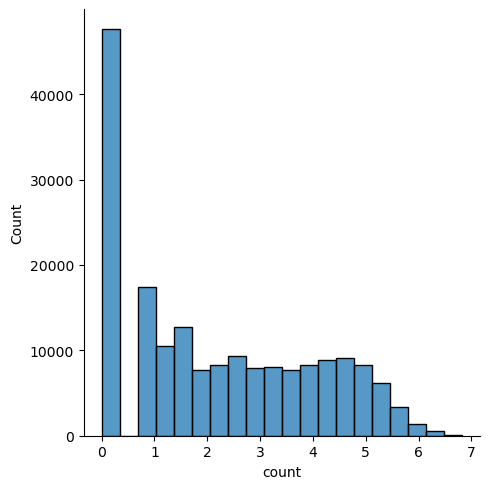

In [98]:
sns.displot(demand["count"],bins=20)

In [99]:
def allocate_drivers(day, quarter, N):
    sub = demand[(demand['weekday']==day) & (demand['quarter_idx']==quarter)]
    if sub.empty:
        return [] 

    sub_sorted = sub.sort_values('count', ascending=False).reset_index(drop=True)
    remaining = N
    allocation = []  
    for idx, row in sub_sorted.iterrows():
        if remaining <= 0:
            break
        demand_count = int(row['count'])
        cell = (int(row['lat_idx']), int(row['lon_idx']))
        assign = demand_count if demand_count <= remaining else remaining
        if assign > 0:
            allocation.append((cell[0], cell[1], assign))
        remaining -= assign
    return allocation

alloc_example = allocate_drivers(day=0, quarter=0, N=50)
print("Przydział kierowców (lat_idx, lon_idx, liczba) dla poniedziałek 00:00, N=50:\n", alloc_example[:5])


Przydział kierowców (lat_idx, lon_idx, liczba) dla poniedziałek 00:00, N=50:
 [(56, 44, 5), (52, 42, 4), (54, 42, 4), (58, 45, 4), (51, 45, 4)]


In [100]:
days = ["Pon", "Wt", "Śr", "Czw", "Pt", "Sob", "Nd"]
day_widget = widgets.Dropdown(options=[(name, i) for i, name in enumerate(days)], description="Dzień:")

time_labels = [f"{h:02d}:{m:02d}" for h in range(24) for m in [0,15,30,45]]
time_widget = widgets.SelectionSlider(options=[(time_labels[i], i) for i in range(len(time_labels))],
                                      description="Czas:", continuous_update=False)


driver_widget = widgets.IntSlider(value=50, min=0, max=300, step=10, description="Liczba taxi:")

In [101]:
def create_map(allocation):
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    if not allocation:
        return m 
    
    max_drivers = max([a[2] for a in allocation])
    
    colormap = linear.YlOrRd_09.scale(0, max_drivers)
    colormap.caption = "Liczba przydzielonych kierowców"
    colormap.add_to(m)
    
    for (lat_i, lon_j, count) in allocation:
        if count <= 0:
            continue
        lat_low = min_lat + lat_i * lat_step
        lat_high = lat_low + lat_step
        lon_low = min_lon + lon_j * lon_step
        lon_high = lon_low + lon_step
        
        color = colormap(count)
        
        folium.Rectangle(
            bounds=[(lat_low, lon_low), (lat_high, lon_high)],
            fill=True, color=color, fill_opacity=0.6, weight=0
        ).add_to(m)
        
        mid_lat = (lat_low + lat_high) / 2
        mid_lon = (lon_low + lon_high) / 2

        folium.map.Marker(
            [mid_lat, mid_lon],
            icon=folium.DivIcon(
                html=f"""<div style="font-size: 12pt; font-weight: bold; color: black">{count}</div>"""
            )
        ).add_to(m)
        
    return m

def update_map(day, quarter, drivers):
    alloc = allocate_drivers(day, quarter, drivers)
    m = create_map(alloc)
    display(m)

widgets.interactive_output(update_map, {'day': day_widget, 'quarter': time_widget, 'drivers': driver_widget})

Output()

In [102]:
display(day_widget, time_widget, driver_widget)

Dropdown(description='Dzień:', options=(('Pon', 0), ('Wt', 1), ('Śr', 2), ('Czw', 3), ('Pt', 4), ('Sob', 5), (…

SelectionSlider(continuous_update=False, description='Czas:', options=(('00:00', 0), ('00:15', 1), ('00:30', 2…

IntSlider(value=50, description='Liczba taxi:', max=300, step=10)

# -----------------------------------------------------------------------------

# Jak wygląda ta wizualizacja:

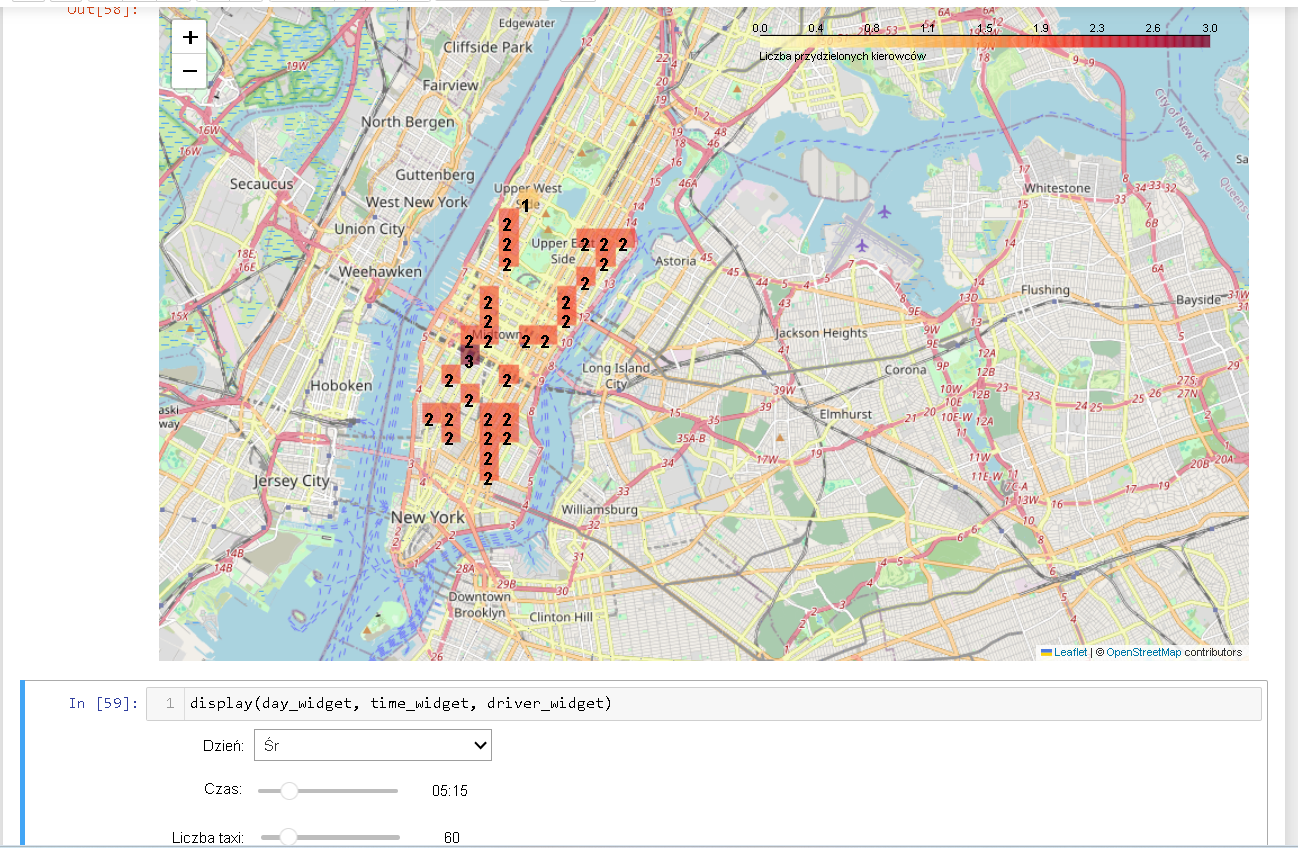

In [64]:
display(Image.open("mapa_rozlozenia_taxi.png"))

# -----------------------------------------------------------------------------

# Przetwarzanie danych wejściowych i wyjściowych do modelu machine learning:

In [2]:
#dfML = df4 lub 
dfML = pd.read_csv("dane_obrobione_taxi.csv")
dfML.drop(['Unnamed: 0','Day',
       'Pickup_Hour', 'Pickup_Minute', 'Trip_time_hours', 'Trip_dist_in_degrees',
       'Trip_dist_miles_converted_degrees', 'diff_dist_degrees_converted',
       'is_valid_total', 'geometry', 'name_left', 'is_in_nyc', 'name_right'],axis=1, inplace=True)

In [3]:
dfML.dtypes

vendor_name               object
Trip_Pickup_DateTime      object
Trip_Dropoff_DateTime     object
Passenger_Count            int64
Trip_Distance            float64
Start_Lon                float64
Start_Lat                float64
End_Lon                  float64
End_Lat                  float64
Payment_Type              object
Fare_Amt                 float64
surcharge                float64
Tip_Amt                  float64
Tolls_Amt                float64
Total_Amt                float64
Trip_time                 object
Trip_velocity            float64
price_per_mile           float64
dtype: object

In [4]:
dfML["Trip_Pickup_DateTime"] = pd.to_datetime(dfML["Trip_Pickup_DateTime"], format='%Y-%m-%d %H:%M:%S', errors='coerce')
dfML.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
1         DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
2         CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
3         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
4         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

   Trip_Distance  Start_Lon  Start_Lat    End_Lon    End_Lat Payment_Type  \
0            5.0 -73.974267  40.790955 -73.996558  40.731849       CREDIT   
1            1.2 -73.989806  40.735006 -73.985021  40.724494         CASH   
2            1.6 -73.969690  40.749244 -73.990413  40.751082       Credit   
3            2.3 -74.006100  40.748432 -73.978437  40.762481         Cash   
4            2.1 -73.983339  40.744782 -73.981160  40.720835         CASH   

   Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Total_Amt        Trip_time  \
0      14.9        0.5     3.05        0.0      18.45  0 days 00:21:02   
1       6.1        0.5     0.00        0.0       6.60  0 days 00:07:36   
2       8.7        0.0     1.30        0.0      10.00  0 days 00:11:19   
3       7.7        0.0     0.00        0.0       7.70  0 days 00:06:58   
4       7.3        0.0     0.00        0.0       7.30  0 days 00:08:41   

   Trip_velocity  price_per_mile  
0      14.263074        2.380000  
1       9.473684        2.583333  
2       8.483063        3.562500  
3      19.808612        2.043478  
4      14.510557        2.047619

In [5]:
# wyciąganie dni tygodnia

In [6]:
dfML["weekday"] = dfML["Trip_Pickup_DateTime"].dt.day_name()

In [7]:
dfML.drop(["Start_Lon", "Start_Lat", "End_Lon","End_Lat"], axis=1, inplace=True)

In [8]:
dfML["Payment_Type"].value_counts()

Payment_Type
CASH         2889774
Cash         2757259
Credit       1356771
CREDIT         89154
No Charge      13920
Dispute         2806
Name: count, dtype: int64

In [9]:
dfML['Payment_Type'] = dfML['Payment_Type'].str.lower()
def map_payment_type(x):
    if x == 'cash':
        return 'Cash'
    elif x == 'credit':
        return 'Credit'
    else:
        return 'Other'
dfML['Payment_Type'] = dfML['Payment_Type'].apply(map_payment_type)

In [10]:
dfML["Payment_Type"].value_counts()

Payment_Type
Cash      5647033
Credit    1445925
Other       16726
Name: count, dtype: int64

In [11]:
dfML.head()

vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  \
0         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
1         DDS  2009-01-16 22:35:59   2009-01-16 22:43:35                2   
2         CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   
3         CMT  2009-01-05 06:21:43   2009-01-05 06:28:41                1   
4         DDS  2009-01-20 13:44:02   2009-01-20 13:52:43                2   

   Trip_Distance Payment_Type  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  \
0            5.0       Credit      14.9        0.5     3.05        0.0   
1            1.2         Cash       6.1        0.5     0.00        0.0   
2            1.6       Credit       8.7        0.0     1.30        0.0   
3            2.3         Cash       7.7        0.0     0.00        0.0   
4            2.1         Cash       7.3        0.0     0.00        0.0   

   Total_Amt        Trip_time  Trip_velocity  price_per_mile   weekday  
0      18.45  0 days 00:21:02      14.263074        2.380000  Thursday  
1       6.60  0 days 00:07:36       9.473684        2.583333    Friday  
2      10.00  0 days 00:11:19       8.483063        3.562500    Monday  
3       7.70  0 days 00:06:58      19.808612        2.043478    Monday  
4       7.30  0 days 00:08:41      14.510557        2.047619   Tuesday

In [12]:
dfML.drop(["Trip_Pickup_DateTime","Trip_Dropoff_DateTime","Total_Amt"],axis=1, inplace=True)

In [13]:
dfML["Trip_time"] = pd.to_timedelta(dfML["Trip_time"])
dfML["Trip_hours"] = (dfML["Trip_time"].dt.total_seconds() // 3600).astype(int)
dfML["Trip_minutes"] = ((dfML["Trip_time"].dt.total_seconds() // 60) % 60).astype(int)

In [14]:
dfML.drop(["Trip_time"],axis=1, inplace=True)

In [15]:
dfML = pd.get_dummies(dfML, columns=["vendor_name","Payment_Type","weekday","Passenger_Count"], drop_first=True)

In [16]:
dfML.head()

Trip_Distance  Fare_Amt  surcharge  Tip_Amt  Tolls_Amt  Trip_velocity  \
0            5.0      14.9        0.5     3.05        0.0      14.263074   
1            1.2       6.1        0.5     0.00        0.0       9.473684   
2            1.6       8.7        0.0     1.30        0.0       8.483063   
3            2.3       7.7        0.0     0.00        0.0      19.808612   
4            2.1       7.3        0.0     0.00        0.0      14.510557   

   price_per_mile  Trip_hours  Trip_minutes  vendor_name_DDS  ...  \
0        2.380000           0            21             True  ...   
1        2.583333           0             7             True  ...   
2        3.562500           0            11            False  ...   
3        2.043478           0             6            False  ...   
4        2.047619           0             8             True  ...   

   weekday_Saturday  weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
0             False           False              True            False   
1             False           False             False            False   
2             False           False             False            False   
3             False           False             False            False   
4             False           False             False             True   

   weekday_Wednesday  Passenger_Count_2  Passenger_Count_3  Passenger_Count_4  \
0              False              False              False              False   
1              False               True              False              False   
2              False              False              False              False   
3              False              False              False              False   
4              False               True              False              False   

   Passenger_Count_5  Passenger_Count_6  
0              False              False  
1              False              False  
2              False              False  
3              False              False  
4              False              False  

[5 rows x 24 columns]

<IPython.core.display.Javascript object>


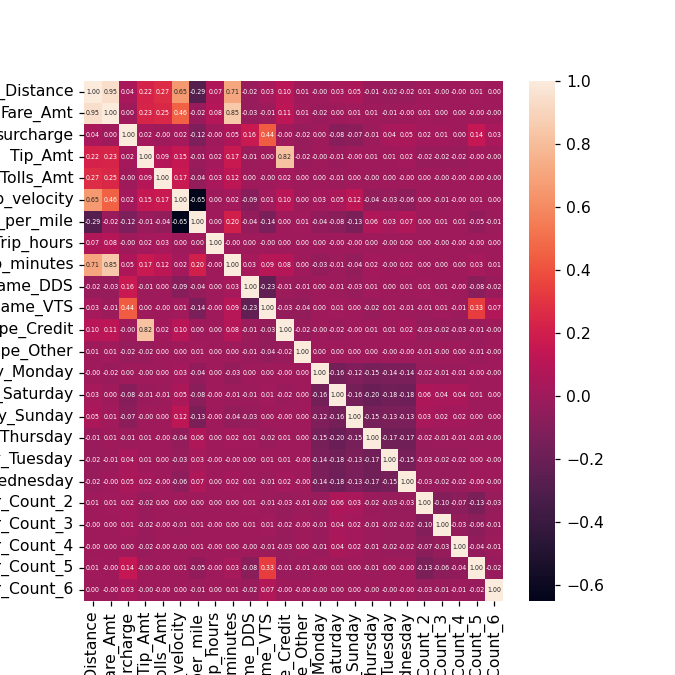

<Axes: >

In [88]:
plt.figure(figsize=(6,6))
sns.heatmap(dfML.corr(),annot=True,annot_kws={"fontsize":4}, fmt=".2f")

<IPython.core.display.Javascript object>


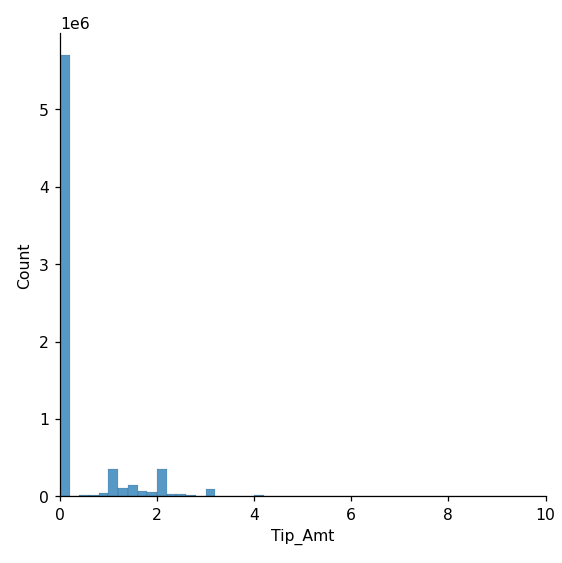

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [121]:
sns.displot(dfML["Tip_Amt"], bins=500)
plt.xlim(0,10)
plt.show()

<IPython.core.display.Javascript object>


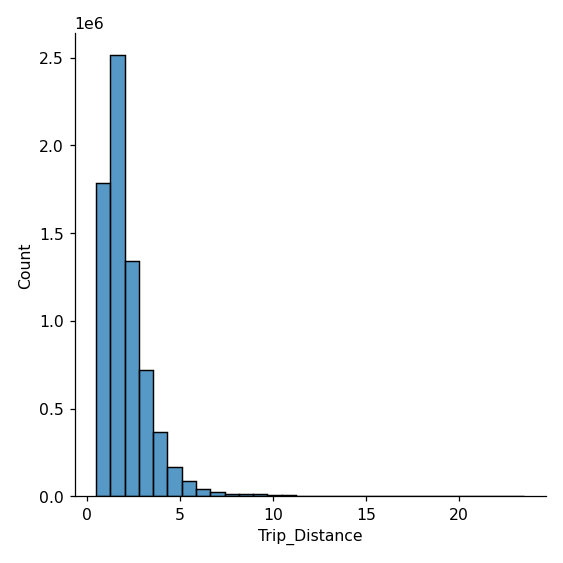

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [111]:
    sns.displot(dfML, x="Trip_Distance", bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


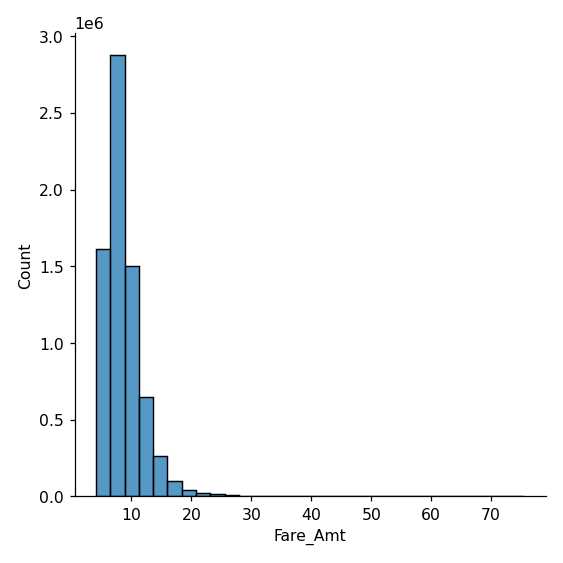

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [112]:
    sns.displot(dfML, x='Fare_Amt', bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


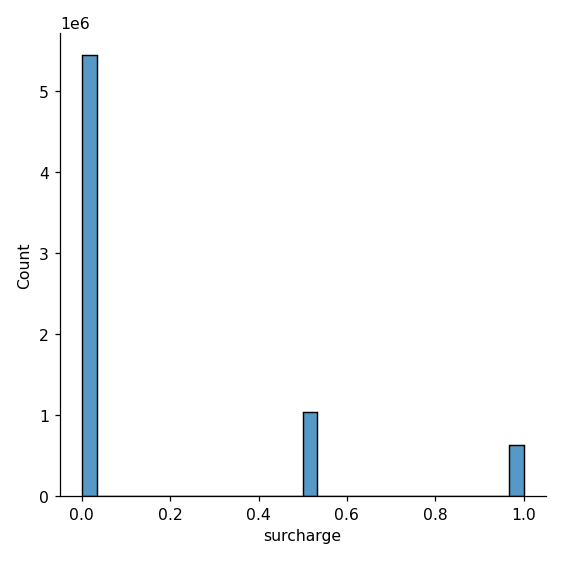

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [113]:
    sns.displot(dfML, x='surcharge', bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


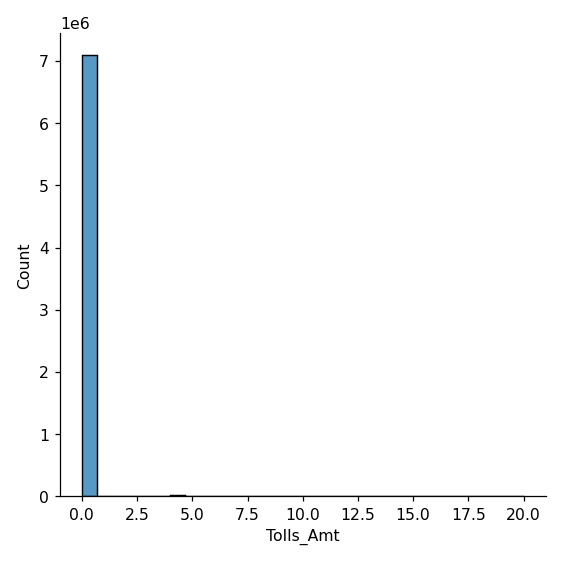

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [114]:
    sns.displot(dfML, x='Tolls_Amt', bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


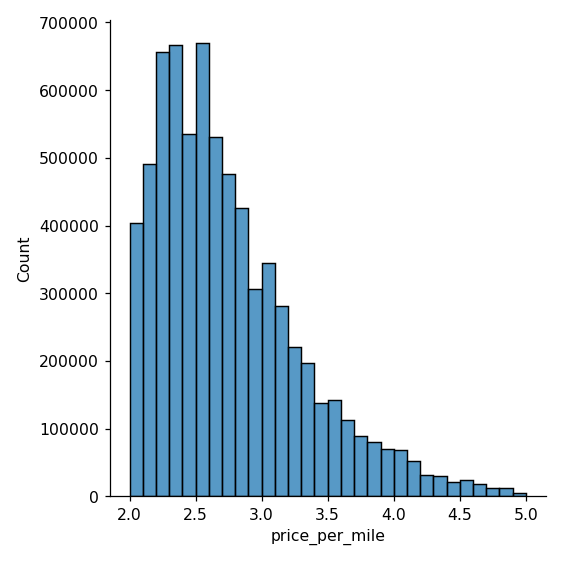

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [117]:
    sns.displot(dfML, x='price_per_mile', bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


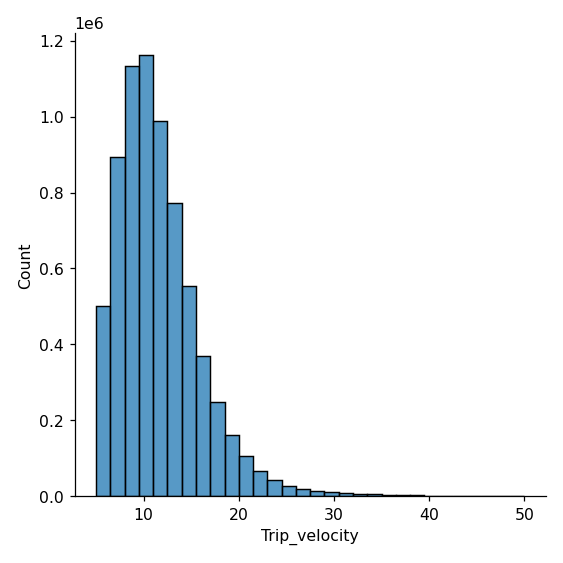

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [118]:
    sns.displot(dfML, x='Trip_velocity', bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


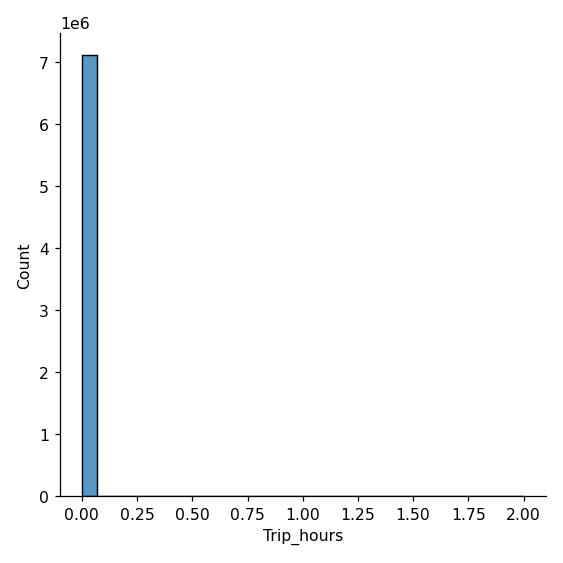

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [119]:
    sns.displot(dfML, x='Trip_hours', bins=30, kde=False)
    plt.show()

<IPython.core.display.Javascript object>


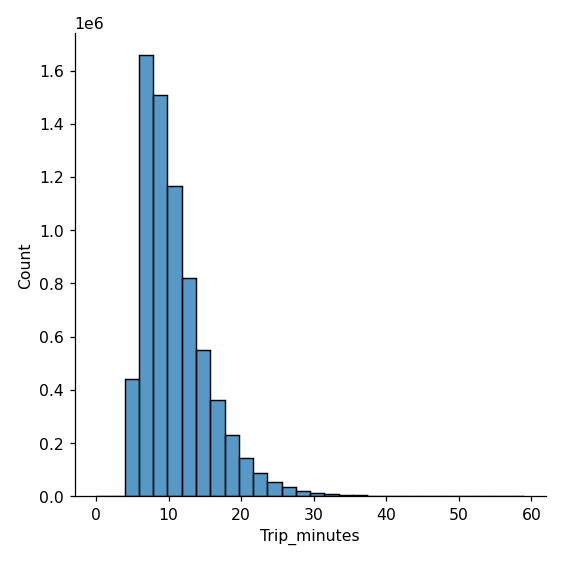

C:\Users\marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [120]:
    sns.displot(dfML, x='Trip_minutes', bins=30, kde=False)
    plt.show()

In [17]:
dfML.columns

Index(['Trip_Distance', 'Fare_Amt', 'surcharge', 'Tip_Amt', 'Tolls_Amt',
       'Trip_velocity', 'price_per_mile', 'Trip_hours', 'Trip_minutes',
       'vendor_name_DDS', 'vendor_name_VTS', 'Payment_Type_Credit',
       'Payment_Type_Other', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'Passenger_Count_2', 'Passenger_Count_3',
       'Passenger_Count_4', 'Passenger_Count_5', 'Passenger_Count_6'],
      dtype='object')

In [38]:
# Porzucamy kolumnę z liczbą godzin przejazdu i Tolls amount żeby nie popełnić błędu niezbalansowania klasowego danych

In [18]:
dfML.drop(['Trip_hours','Tolls_Amt'], axis=1, inplace=True)

In [19]:
y = dfML['Tip_Amt']  
X = dfML.drop('Tip_Amt', axis=1)

# -----------------------------------------------------------------------------

# Zmienna wyjściowa z modelu Machine Learning:

> Tip_Amt - Kwota napiwku przekazana kierowcy.

# Zmienne wejściowe do modelu Machine Learning:

> Trip_Distance - dystans przebyty przez taksówkę

> Fare_Amt - Kwota podstawowej opłaty za przejazd.

> Surcharge - Dodatkowa opłata doliczana do podstawowej ceny przejazdu

> Tolls_Amt - Kwota dodatkowych opłat drogowych.

> Trip_velocity - Średnia prędkość przejazdu – wyliczana na podstawie dystansu i czasu podróży.

> price_per_mile - Cena za milę w dolarach.

> Trip_minutes - Czas trwania podróży w minutach.

> vendor_name_DDS, vendor_name_VTS - Zmienna binarne wskazująca, czy przewoźnik należy do konkretnej firmy.

> weekday_Monday, weekday_Saturday, weekday_Sunday, weekday_Thursday, weekday_Tuesday, weekday_Wednesday - Zmienne binarne zakodowane metodą dummies, informujące o dniu tygodnia, w którym odbył się przejazd.

> Passenger_Count_2, Passenger_Count_3, Passenger_Count_4, Passenger_Count_5, Passenger_Count_6 - Zmienne binarne wskazujące liczbę pasażerów w pojeździe (True/False).

# -----------------------------------------------------------------------------

# W ramach uczenia maszynowego rozważę 5 modeli: 

# -----------------------------------------------------------------------------

# Sieć Neuronowa z funkcją dezaktywazji neuronów:

In [22]:
continuous_columns = [col for col in X.columns if X[col].nunique() > 2]
binary_columns = [col for col in X.columns if X[col].nunique() == 2]
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X[continuous_columns])
X_scaled = X.copy()
X_scaled[continuous_columns] = X_continuous_scaled

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [29]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 119s 832us/step - loss: 0.1907 - mae: 0.1421 - mse: 0.1907 - val_loss: 0.1745 - val_mae: 0.1164 - val_mse: 0.1745
Epoch 2/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 120s 840us/step - loss: 0.1761 - mae: 0.1378 - mse: 0.1761 - val_loss: 0.1758 - val_mae: 0.1090 - val_mse: 0.1758
Epoch 3/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 117s 824us/step - loss: 0.1896 - mae: 0.1387 - mse: 0.1896 - val_loss: 0.1738 - val_mae: 0.1185 - val_mse: 0.1738
Epoch 4/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 128s 897us/step - loss: 0.1751 - mae: 0.1385 - mse: 0.1751 - val_loss: 0.1800 - val_mae: 0.1157 - val_mse: 0.1800
Epoch 5/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 130s 914us/step - loss: 0.1914 - mae: 0.1384 - mse: 0.1914 - val_loss: 0.1761 - val_mae: 0.1184 - val_mse: 0.1761
Test MSE: 0.17921870946884155
Test MAE: 0.11889034509658813


In [56]:
#joblib.dump(model, "deepL_NYC.pkl")
#joblib.dump(history.history, "Deep_NN_history.pkl")

<IPython.core.display.Javascript object>


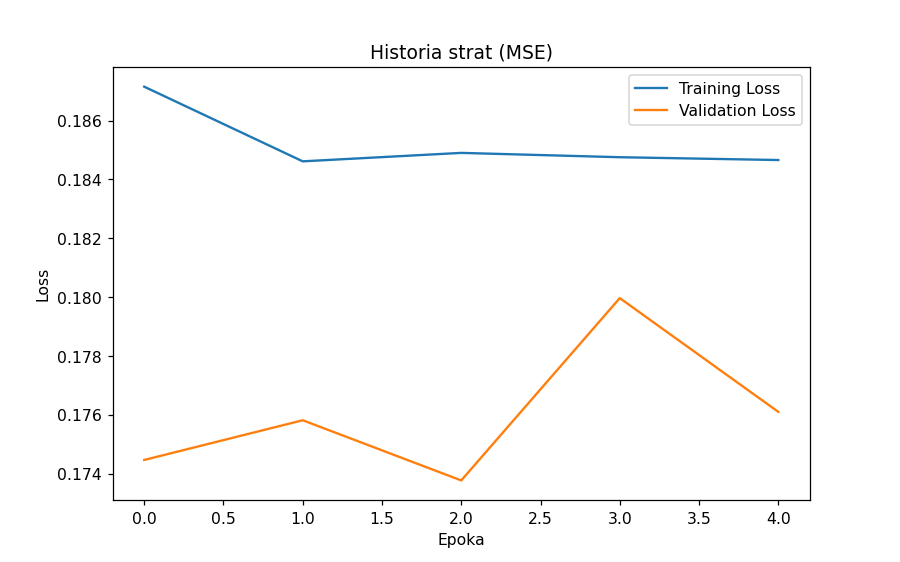

In [2]:
history_dict = joblib.load("Deep_NN_history.pkl")

plt.figure(figsize=(8,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title("Historia strat (MSE)")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Optymalizacja parametrów sieci neuronowej:

In [32]:
df_sample = dfML.sample(n=1_000_000)

In [34]:
y_sample = df_sample['Tip_Amt']  
X_sample = df_sample.drop('Tip_Amt', axis=1)

In [37]:

continuous_columns = [col for col in X_sample.columns if X[col].nunique() > 2]
binary_columns = [col for col in X_sample.columns if X[col].nunique() == 2]
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_sample[continuous_columns])
X_scaled = X_sample.copy()
X_scaled[continuous_columns] = X_continuous_scaled

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sample, test_size=0.20, random_state=42)

In [39]:
def objective(trial):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    num_layers = trial.suggest_int('num_layers', 1, 3)
    for i in range(num_layers):
        num_units = trial.suggest_int(f'num_units_{i}', 16, 128)
        model.add(layers.Dense(num_units, activation='relu'))
        dropout_rate = trial.suggest_float(f'dropout_rate_{i}', 0.0, 0.4)
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=32, verbose=1)
    
    val_mse = history.history['val_mse'][-1]
    return val_mse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Najlepsze parametry:", study.best_params)


[I 2025-03-06 11:34:36,331] A new study created in memory with name: no-name-be9efe7c-2163-4bfb-9eae-9c861243496e


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 13s 625us/step - loss: 0.2120 - mse: 0.2120 - val_loss: 0.1459 - val_mse: 0.1459
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 13s 624us/step - loss: 0.1716 - mse: 0.1716 - val_loss: 0.1457 - val_mse: 0.1457
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 12s 622us/step - loss: 0.1749 - mse: 0.1749 - val_loss: 0.1450 - val_mse: 0.1450


[I 2025-03-06 11:35:14,366] Trial 0 finished with value: 0.14504556357860565 and parameters: {'num_layers': 1, 'num_units_0': 89, 'dropout_rate_0': 0.1099249236969631}. Best is trial 0 with value: 0.14504556357860565.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 762us/step - loss: 0.2114 - mse: 0.2114 - val_loss: 0.1499 - val_mse: 0.1499
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 751us/step - loss: 0.1862 - mse: 0.1862 - val_loss: 0.1501 - val_mse: 0.1501
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 767us/step - loss: 0.1909 - mse: 0.1909 - val_loss: 0.1564 - val_mse: 0.1564


[I 2025-03-06 11:36:00,949] Trial 1 finished with value: 0.15642036497592926 and parameters: {'num_layers': 3, 'num_units_0': 72, 'dropout_rate_0': 0.3930627216761649, 'num_units_1': 112, 'dropout_rate_1': 0.012602715418083799, 'num_units_2': 68, 'dropout_rate_2': 0.3164499052962131}. Best is trial 0 with value: 0.14504556357860565.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 13s 636us/step - loss: 0.1928 - mse: 0.1928 - val_loss: 0.1489 - val_mse: 0.1489
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 12s 613us/step - loss: 0.1650 - mse: 0.1650 - val_loss: 0.1454 - val_mse: 0.1454
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 12s 619us/step - loss: 0.1630 - mse: 0.1630 - val_loss: 0.1448 - val_mse: 0.1448


[I 2025-03-06 11:36:38,929] Trial 2 finished with value: 0.14483273029327393 and parameters: {'num_layers': 1, 'num_units_0': 110, 'dropout_rate_0': 0.007710205762110789}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 748us/step - loss: 0.2418 - mse: 0.2418 - val_loss: 0.1489 - val_mse: 0.1489
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 743us/step - loss: 0.1781 - mse: 0.1781 - val_loss: 0.1613 - val_mse: 0.1613
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 732us/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.1483 - val_mse: 0.1483


[I 2025-03-06 11:37:24,398] Trial 3 finished with value: 0.14829029142856598 and parameters: {'num_layers': 3, 'num_units_0': 73, 'dropout_rate_0': 0.02087563986392249, 'num_units_1': 30, 'dropout_rate_1': 0.33013956820936, 'num_units_2': 72, 'dropout_rate_2': 0.3789218568894995}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 736us/step - loss: 0.2243 - mse: 0.2243 - val_loss: 0.1466 - val_mse: 0.1466
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 713us/step - loss: 0.1817 - mse: 0.1817 - val_loss: 0.1450 - val_mse: 0.1450
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 710us/step - loss: 0.1869 - mse: 0.1869 - val_loss: 0.1464 - val_mse: 0.1464


[I 2025-03-06 11:38:08,609] Trial 4 finished with value: 0.14641214907169342 and parameters: {'num_layers': 3, 'num_units_0': 45, 'dropout_rate_0': 0.13784125277065004, 'num_units_1': 53, 'dropout_rate_1': 0.02663243559830657, 'num_units_2': 49, 'dropout_rate_2': 0.20040377139595106}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 17s 792us/step - loss: 0.2458 - mse: 0.2458 - val_loss: 0.1457 - val_mse: 0.1457
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 688us/step - loss: 0.1839 - mse: 0.1839 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 691us/step - loss: 0.1688 - mse: 0.1688 - val_loss: 0.1459 - val_mse: 0.1459


[I 2025-03-06 11:38:52,918] Trial 5 finished with value: 0.14587877690792084 and parameters: {'num_layers': 2, 'num_units_0': 32, 'dropout_rate_0': 0.18914847716863392, 'num_units_1': 60, 'dropout_rate_1': 0.3729037650804698}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 743us/step - loss: 0.2343 - mse: 0.2343 - val_loss: 0.1898 - val_mse: 0.1898
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 771us/step - loss: 0.1710 - mse: 0.1710 - val_loss: 0.1456 - val_mse: 0.1456
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 755us/step - loss: 0.1629 - mse: 0.1629 - val_loss: 0.1553 - val_mse: 0.1553


[I 2025-03-06 11:39:39,346] Trial 6 finished with value: 0.15528544783592224 and parameters: {'num_layers': 3, 'num_units_0': 46, 'dropout_rate_0': 0.24060234864636498, 'num_units_1': 88, 'dropout_rate_1': 0.003906444244443019, 'num_units_2': 33, 'dropout_rate_2': 0.24736881382130746}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 707us/step - loss: 0.2179 - mse: 0.2179 - val_loss: 0.1455 - val_mse: 0.1455
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 704us/step - loss: 0.1873 - mse: 0.1873 - val_loss: 0.1457 - val_mse: 0.1457
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 696us/step - loss: 0.1732 - mse: 0.1732 - val_loss: 0.1458 - val_mse: 0.1458


[I 2025-03-06 11:40:22,428] Trial 7 finished with value: 0.14584819972515106 and parameters: {'num_layers': 2, 'num_units_0': 74, 'dropout_rate_0': 0.2051408356744724, 'num_units_1': 17, 'dropout_rate_1': 0.1791078394367517}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 13s 609us/step - loss: 0.2386 - mse: 0.2386 - val_loss: 0.1485 - val_mse: 0.1485
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 13s 630us/step - loss: 0.1869 - mse: 0.1869 - val_loss: 0.1493 - val_mse: 0.1493
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 12s 620us/step - loss: 0.2174 - mse: 0.2174 - val_loss: 0.1473 - val_mse: 0.1473


[I 2025-03-06 11:41:00,327] Trial 8 finished with value: 0.14729638397693634 and parameters: {'num_layers': 1, 'num_units_0': 47, 'dropout_rate_0': 0.3329452684338528}. Best is trial 2 with value: 0.14483273029327393.


Epoch 1/3


C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 17s 830us/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.1454 - val_mse: 0.1454
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 18s 896us/step - loss: 0.1836 - mse: 0.1836 - val_loss: 0.1529 - val_mse: 0.1529
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 14s 712us/step - loss: 0.1674 - mse: 0.1674 - val_loss: 0.1448 - val_mse: 0.1448


[I 2025-03-06 11:41:49,933] Trial 9 finished with value: 0.1447807401418686 and parameters: {'num_layers': 2, 'num_units_0': 95, 'dropout_rate_0': 0.2997628723982154, 'num_units_1': 42, 'dropout_rate_1': 0.1960471462696287}. Best is trial 9 with value: 0.1447807401418686.


Najlepsze parametry: {'num_layers': 2, 'num_units_0': 95, 'dropout_rate_0': 0.2997628723982154, 'num_units_1': 42, 'dropout_rate_1': 0.1960471462696287}


In [50]:
#data_for_plot_optimalization = {
#    'num_layers': num_layers_list,
#    'num_units': avg_num_units_list,
#    'val_mse': val_mse_list
#}
#joblib.dump(data_for_plot_optimalization, 'plot_data_optimalization.pkl')

['plot_data_optimalization.pkl']

<IPython.core.display.Javascript object>


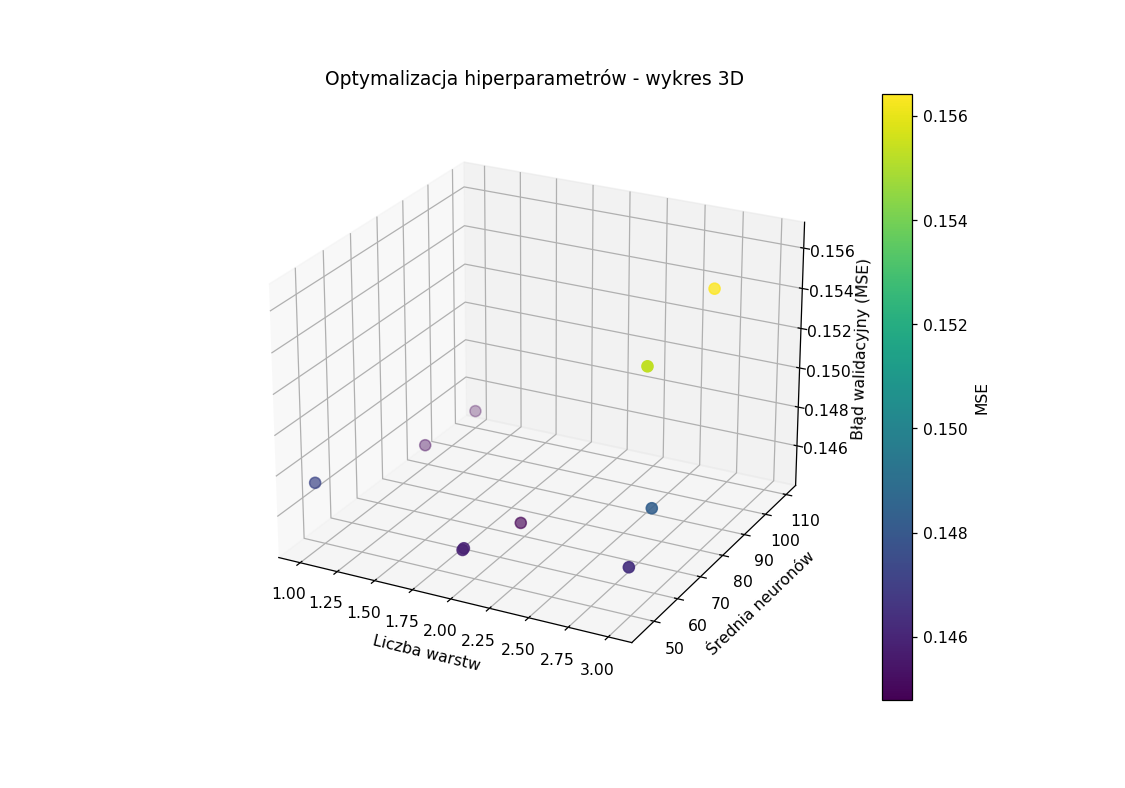

In [3]:
# 1. Wczytaj słownik z danymi
plot_data_optimalization = joblib.load('plot_data_optimalization.pkl')

# 2. Wyodrębnij listy z wartościami
num_layers_list = plot_data_optimalization['num_layers']
avg_num_units_list = plot_data_optimalization['num_units']
val_mse_list = plot_data_optimalization['val_mse']

# 3. Utwórz wykres 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 4. Narysuj scatter
sc = ax.scatter(
    num_layers_list,       # oś X
    avg_num_units_list,    # oś Y
    val_mse_list,          # oś Z
    c=val_mse_list,        # kolory punktów zależne od wartości MSE
    cmap='viridis',
    s=50
)

ax.set_xlabel("Liczba warstw")
ax.set_ylabel("Średnia neuronów")
ax.set_zlabel("Błąd walidacyjny (MSE)")
plt.title("Optymalizacja hiperparametrów - wykres 3D")

# 5. Dodaj legendę w postaci colorbar
fig.colorbar(sc, ax=ax, label='MSE')

plt.show()


# -----------------------------------------------------------------------------

# Zoptymalizowana sieć neuronowa z funkcją dezaktywazji neuronów:

In [70]:
y = dfML['Tip_Amt']  
X = dfML.drop('Tip_Amt', axis=1)

continuous_columns = [col for col in X.columns if X[col].nunique() > 2]
binary_columns = [col for col in X.columns if X[col].nunique() == 2]
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X[continuous_columns])
X_scaled = X.copy()
X_scaled[continuous_columns] = X_continuous_scaled

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [71]:
model1 = Sequential()
model1.add(Dense(95, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dropout(0.2997))
model1.add(Dense(42, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))

model1.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])


history1 = model1.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_mse, test_mae = model1.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

C:\Users\marco\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 113s 791us/step - loss: 0.1871 - mae: 0.1449 - mse: 0.1871 - val_loss: 0.1744 - val_mae: 0.1155 - val_mse: 0.1744
Epoch 2/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 113s 793us/step - loss: 0.1864 - mae: 0.1374 - mse: 0.1864 - val_loss: 0.1745 - val_mae: 0.1134 - val_mse: 0.1745
Epoch 3/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 114s 803us/step - loss: 0.1856 - mae: 0.1398 - mse: 0.1856 - val_loss: 0.1794 - val_mae: 0.1154 - val_mse: 0.1794
Epoch 4/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 111s 780us/step - loss: 0.1812 - mae: 0.1416 - mse: 0.1812 - val_loss: 0.1792 - val_mae: 0.1152 - val_mse: 0.1792
Epoch 5/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 110s 772us/step - loss: 0.1775 - mae: 0.1423 - mse: 0.1775 - val_loss: 0.1740 - val_mae: 0.1122 - val_mse: 0.1740
Epoch 6/100
142194/142194 ━━━━━━━━━━━━━━━━━━━━ 112s 784us/step - loss: 0.1802 - mae: 0.1434 - mse: 0.1802 - val_loss: 0.1759 - val_mae: 0.1088 - val_mse: 0.1759
Epoch 7/100
142194/142194 ━━━━━━━━

In [74]:
#joblib.dump(model1, "deepL_NYC1.pkl")
#joblib.dump(history1.history, "Deep_NN1_history.pkl")

<IPython.core.display.Javascript object>


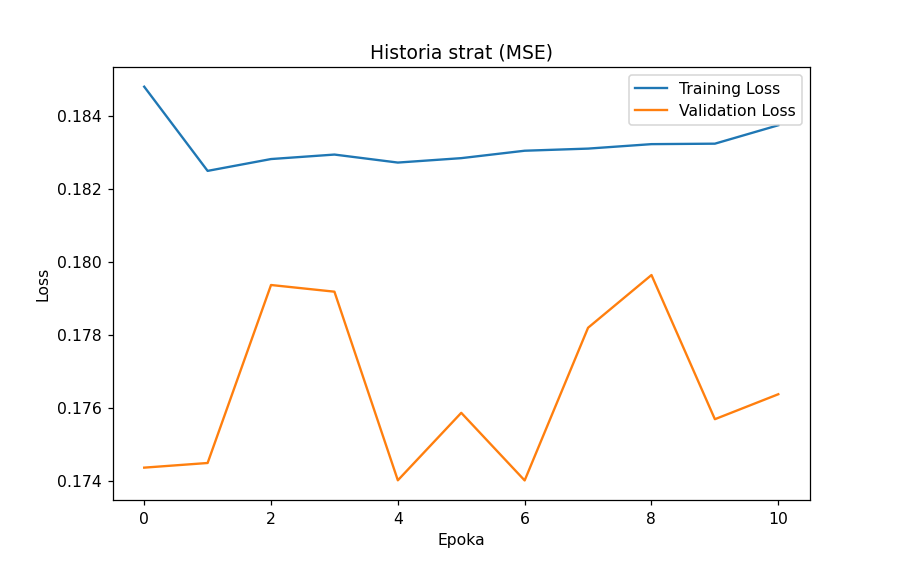

In [4]:
history_dict1 = joblib.load("Deep_NN1_history.pkl")

plt.figure(figsize=(8,5))
plt.plot(history_dict1['loss'], label='Training Loss')
plt.plot(history_dict1['val_loss'], label='Validation Loss')
plt.title("Historia strat (MSE)")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


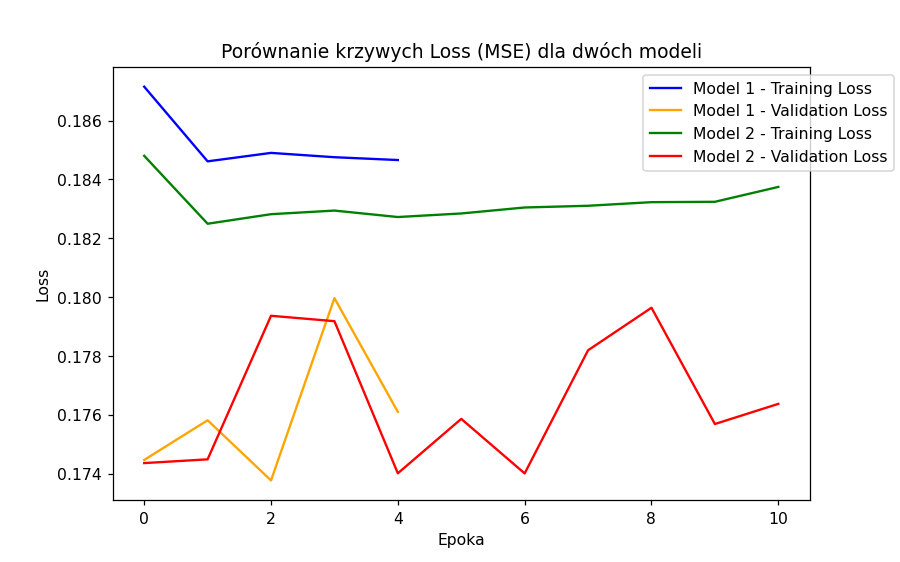

In [5]:
history_dict = joblib.load("Deep_NN_history.pkl")
history_dict1 = joblib.load("Deep_NN1_history.pkl")

plt.figure(figsize=(8, 5))

plt.plot(history_dict['loss'], label='Model 1 - Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Model 1 - Validation Loss', color='orange')

plt.plot(history_dict1['loss'], label='Model 2 - Training Loss', color='green')
plt.plot(history_dict1['val_loss'], label='Model 2 - Validation Loss', color='red')

plt.title("Porównanie krzywych Loss (MSE) dla dwóch modeli")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend(loc='upper left', bbox_to_anchor=(0.75, 1))
plt.show()

# -----------------------------------------------------------------------------

# Liniowa regresja:

In [96]:
df_sample_lin = dfML.sample(n=100_000)

In [21]:
df_sample[]

Trip_Distance  Fare_Amt  surcharge  Tip_Amt  Trip_velocity  \
584577            1.77       6.9        0.0      0.0      13.275000   
1258068           1.77       6.9        0.0      0.0      15.171429   
6547221           4.20      12.9        0.0      0.0      14.580521   
1740883           1.40       7.3        0.0      0.0       8.983957   
4016551           0.95       5.7        0.5      0.0       7.125000   

         price_per_mile  Trip_minutes  vendor_name_DDS  vendor_name_VTS  \
584577         2.203390             8            False             True   
1258068        2.203390             7            False             True   
6547221        2.357143            17            False            False   
1740883        3.071429             9             True            False   
4016551        2.842105             8            False             True   

         Payment_Type_Credit  ...  weekday_Saturday  weekday_Sunday  \
584577                 False  ...             False            True   
1258068                False  ...             False           False   
6547221                False  ...              True           False   
1740883                False  ...             False           False   
4016551                False  ...             False           False   

         weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
584577              False            False              False   
1258068             False            False               True   
6547221             False            False              False   
1740883              True            False              False   
4016551              True            False              False   

         Passenger_Count_2  Passenger_Count_3  Passenger_Count_4  \
584577               False              False              False   
1258068               True              False              False   
6547221              False              False              False   
1740883              False              False              False   
4016551              False              False              False   

         Passenger_Count_5  Passenger_Count_6  
584577               False              False  
1258068              False              False  
6547221              False              False  
1740883              False              False  
4016551              False              False  

[5 rows x 22 columns]

<IPython.core.display.Javascript object>


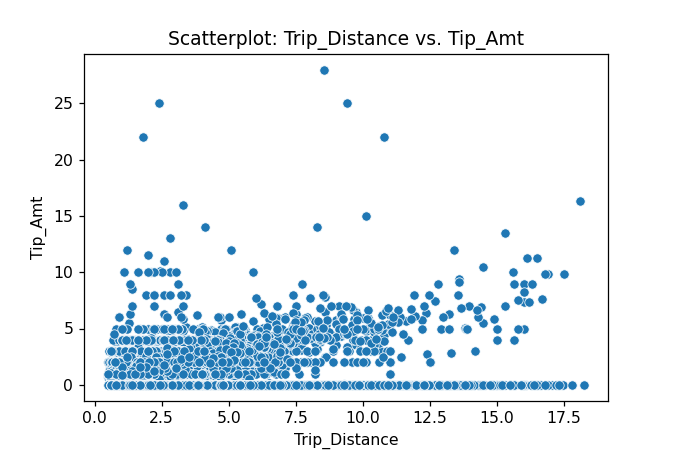

<IPython.core.display.Javascript object>


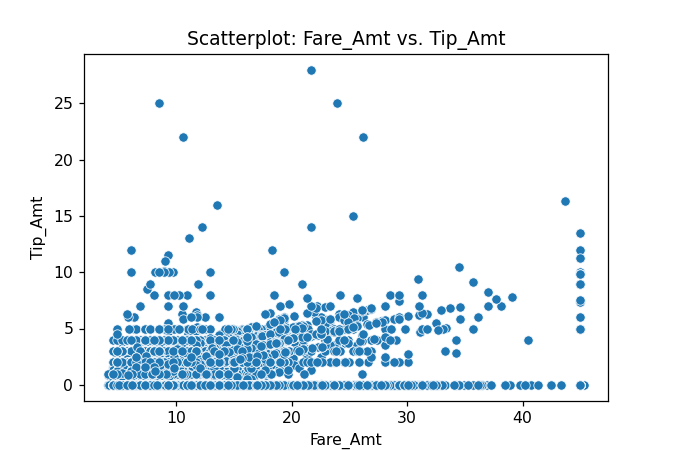

<IPython.core.display.Javascript object>


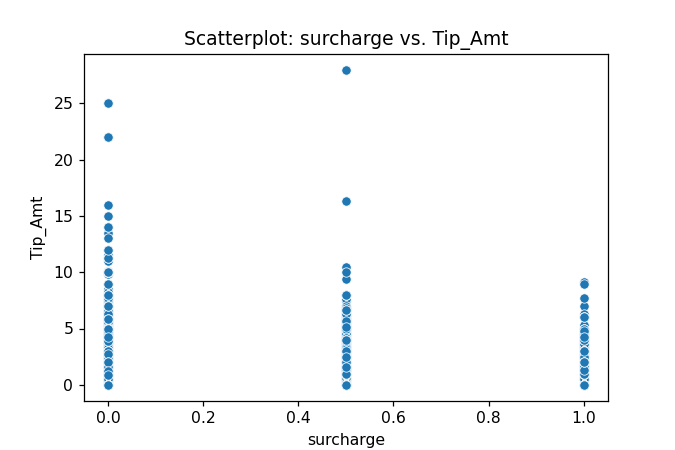

<IPython.core.display.Javascript object>


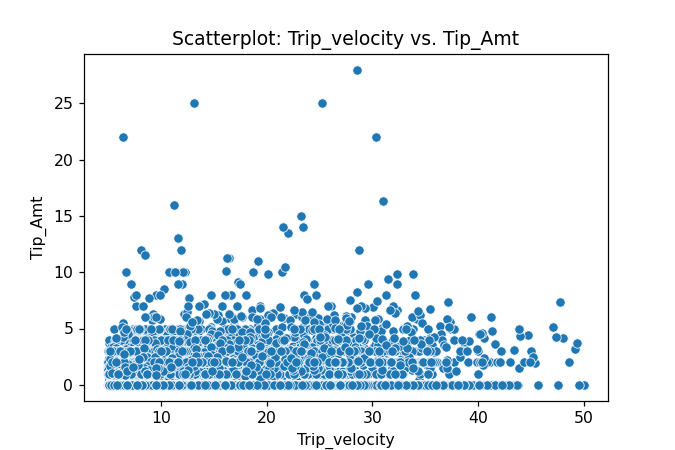

<IPython.core.display.Javascript object>


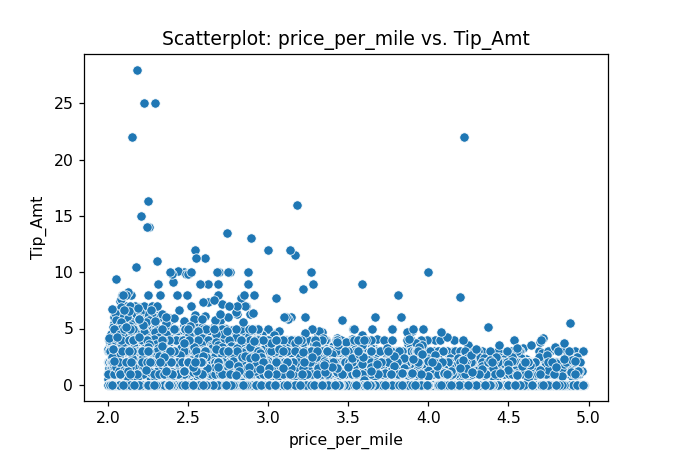

<IPython.core.display.Javascript object>


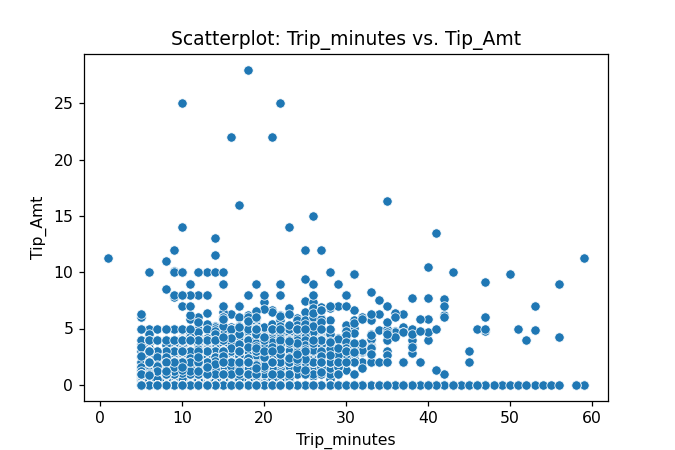

In [23]:
num_cols = df_sample.select_dtypes(include='number').columns
num_cols = [col for col in num_cols if col != 'Tip_Amt']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_sample[col], y=df_sample['Tip_Amt'])
    plt.title(f'Scatterplot: {col} vs. Tip_Amt')
    plt.xlabel(col)
    plt.ylabel('Tip_Amt')
    plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Treningowy: ", X_train.shape[0],"Testowy: ", X_test.shape[0])

Treningowy:  5687747 Testowy:  1421937


In [26]:
lin_reg_cv = LinearRegression()
cv_scores = cross_val_score(lin_reg_cv, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [27]:
print("Regresja liniowa - średnie RMSE (5-krotna walidacja krzyżowa):", -cv_scores.mean())

Regresja liniowa - średnie RMSE (5-krotna walidacja krzyżowa): 0.4624264345164698


In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

In [30]:
#joblib.dump(lin_reg, "lin_reg_NYC.pkl")

# -----------------------------------------------------------------------------

# Random Forest:

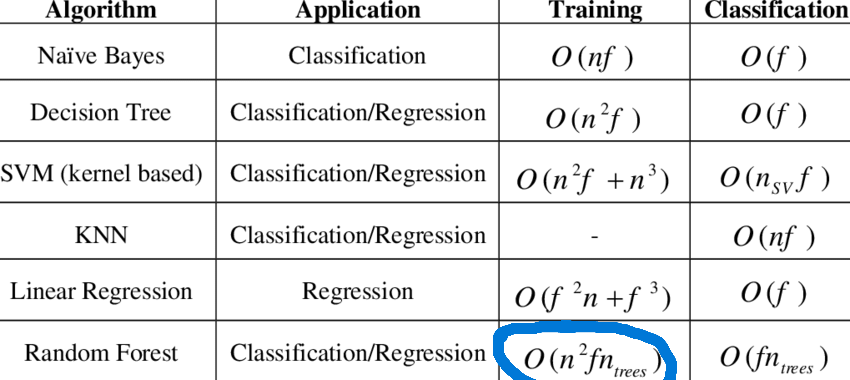

In [31]:
display(Image.open("Computational-Complexity-of-Machine-Learning-algorithms.png"))

Z racji bardzo dużej złożoności obliczeniowej analizę przeprowadzę na próbie, co jest mniej miarodajne, lecz ograniczy czas uczenia

In [73]:
df_sample = dfML.sample(n=1_000_000)

In [74]:
y = df_sample['Tip_Amt']  
X = df_sample.drop('Tip_Amt', axis=1)

In [75]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.20, random_state=42)

In [76]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_reg.predict(X_test_rf)

In [78]:
#joblib.dump(rf_reg, "rf_reg_NYC.pkl")

# -----------------------------------------------------------------------------

# GradientBoosting:

In [64]:
y = dfML['Tip_Amt']  
X = dfML.drop('Tip_Amt', axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)
y_pred_gb = gb_reg.predict(X_test)

In [68]:
#joblib.dump(gb_reg, "gb_reg_NYC.pkl")

# -----------------------------------------------------------------------------

# Porównanie modeli: XGboost, Linear Regression, Random Forest

In [108]:
with open("variables.pkl", "rb") as f:
    vars_dict = pickle.load(f)

y_test     = vars_dict["y_test"]
y_pred_lin = vars_dict["y_pred_lin"]
y_test_rf  = vars_dict["y_test_rf"]
y_pred_rf  = vars_dict["y_pred_rf"]
y_pred_gb  = vars_dict["y_pred_gb"]

rmse_lin = vars_dict["rmse_lin"]
mae_lin  = vars_dict["mae_lin"]
r2_lin   = vars_dict["r2_lin"]

rmse_rf = vars_dict["rmse_rf"]
mae_rf  = vars_dict["mae_rf"]
r2_rf   = vars_dict["r2_rf"]

rmse_gb = vars_dict["rmse_gb"]
mae_gb  = vars_dict["mae_gb"]
r2_gb   = vars_dict["r2_gb"]


In [109]:
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Wyniki na zbiorze testowym:")
print(f"Regresja Liniowa  - RMSE: {rmse_lin:.3f}, MAE: {mae_lin:.3f}, R^2: {r2_lin:.3f}")
print(f"Random Forest     - RMSE: {rmse_rf:.3f}, MAE: {mae_rf:.3f}, R^2: {r2_rf:.3f}")
print(f"Gradient Boosting - RMSE: {rmse_gb:.3f}, MAE: {mae_gb:.3f}, R^2: {r2_gb:.3f}")

Wyniki na zbiorze testowym:
Regresja Liniowa  - RMSE: 0.471, MAE: 0.182, R^2: 0.696
Random Forest     - RMSE: 0.456, MAE: 0.119, R^2: 0.719
Gradient Boosting - RMSE: 0.422, MAE: 0.107, R^2: 0.756


<IPython.core.display.Javascript object>


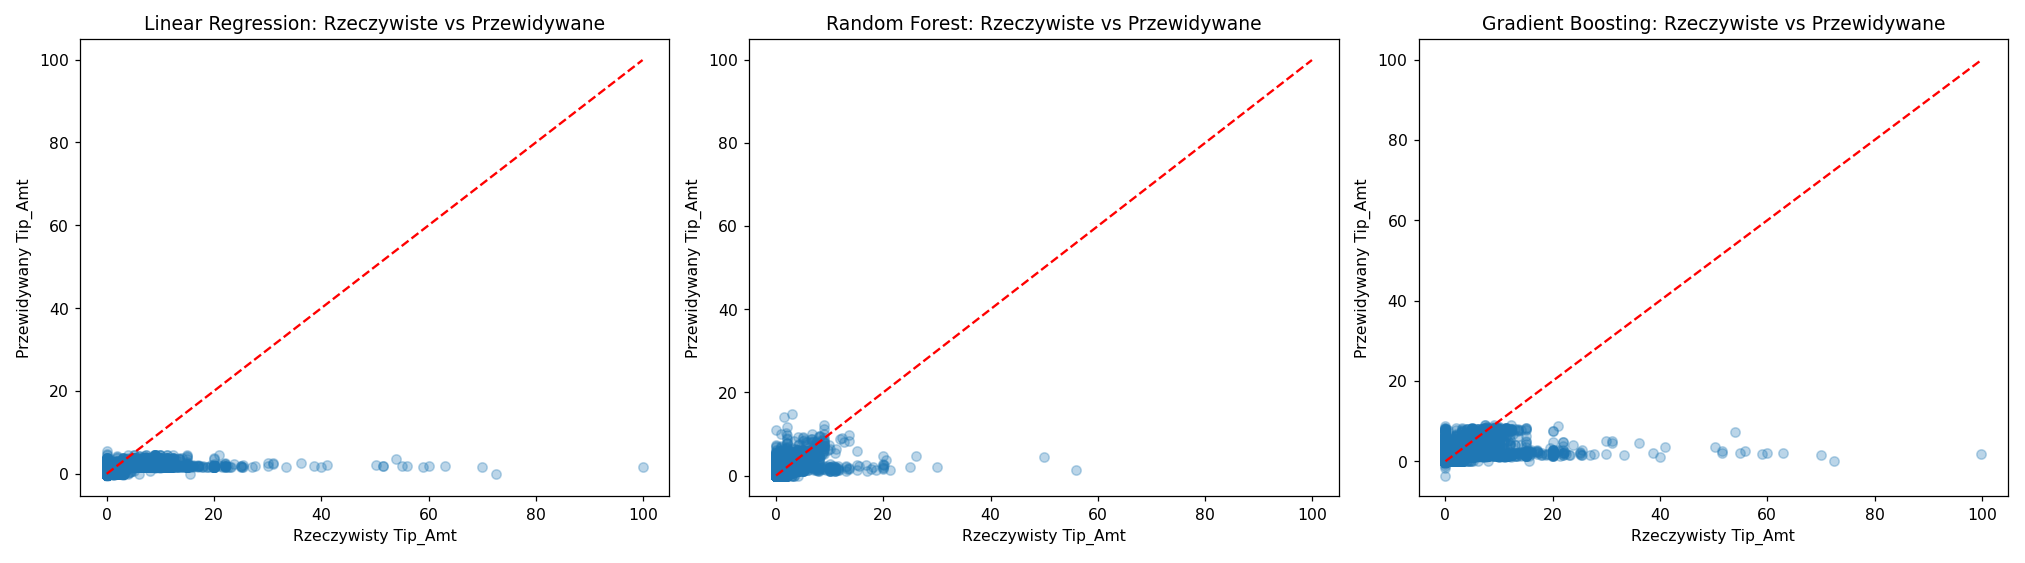

In [110]:
plt.figure(figsize=(18,5))

# Regresja liniowa
plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_lin, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Linear Regression: Rzeczywiste vs Przewidywane")
plt.xlabel("Rzeczywisty Tip_Amt")
plt.ylabel("Przewidywany Tip_Amt")

# Random Forest
plt.subplot(1,3,2)
plt.scatter(y_test_rf, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Random Forest: Rzeczywiste vs Przewidywane")
plt.xlabel("Rzeczywisty Tip_Amt")
plt.ylabel("Przewidywany Tip_Amt")

# Gradient Boosting
plt.subplot(1,3,3)
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Gradient Boosting: Rzeczywiste vs Przewidywane")
plt.xlabel("Rzeczywisty Tip_Amt")
plt.ylabel("Przewidywany Tip_Amt")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


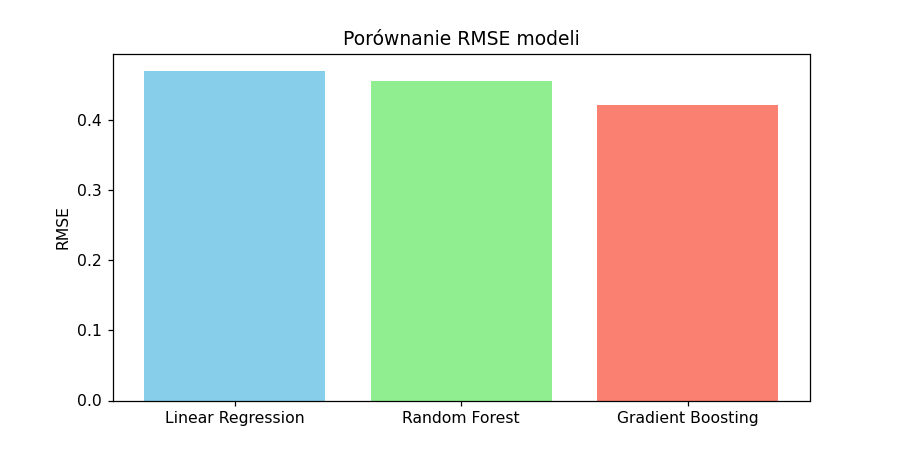

<IPython.core.display.Javascript object>


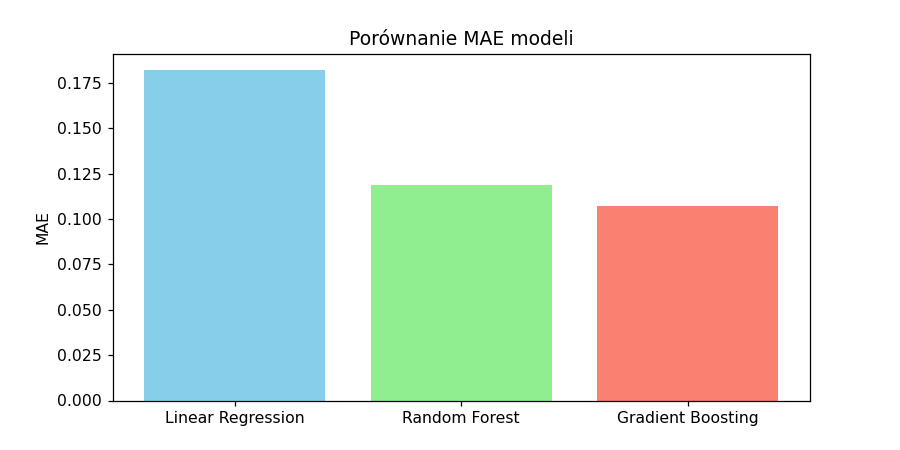

<IPython.core.display.Javascript object>


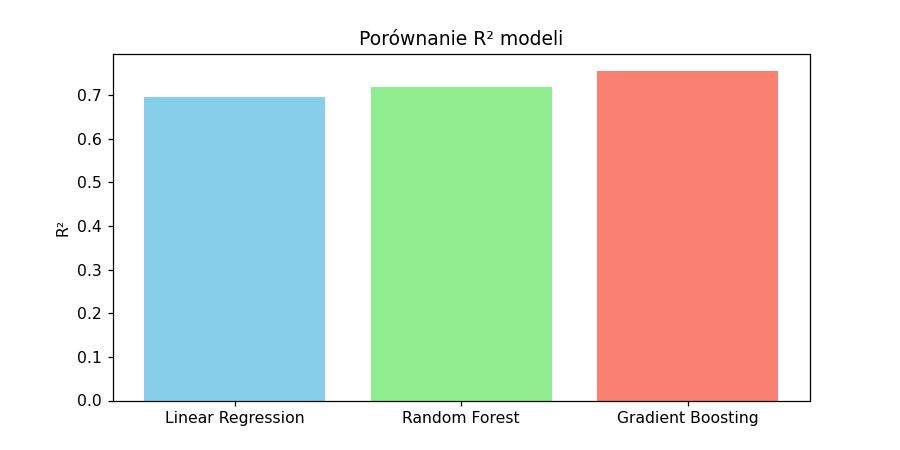

In [112]:
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
rmse_values = [rmse_lin, rmse_rf, rmse_gb]
mae_values = [mae_lin, mae_rf, mae_gb]
r2_values = [r2_lin, r2_rf, r2_gb]

plt.figure(figsize=(8,4))
plt.bar(models, rmse_values, color=['skyblue','lightgreen','salmon'])
plt.title("Porównanie RMSE modeli")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(models, mae_values, color=['skyblue','lightgreen','salmon'])
plt.title("Porównanie MAE modeli")
plt.ylabel("MAE")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(models, r2_values, color=['skyblue','lightgreen','salmon'])
plt.title("Porównanie R² modeli")
plt.ylabel("R²")
plt.show()

In [107]:
"""
variables_to_save = {
    "y_test": y_test,
    "y_pred_lin": y_pred_lin,
    "y_test_rf": y_test_rf,
    "y_pred_rf": y_pred_rf,
    "y_pred_gb": y_pred_gb,
    "rmse_lin": rmse_lin,
    "mae_lin": mae_lin,
    "r2_lin": r2_lin,
    "rmse_rf": rmse_rf,
    "mae_rf": mae_rf,
    "r2_rf": r2_rf,
    "rmse_gb": rmse_gb,
    "mae_gb": mae_gb,
    "r2_gb": r2_gb
}

with open("variables.pkl", "wb") as f:
    pickle.dump(variables_to_save, f)
"""

# -----------------------------------------------------------------------------

# Model podwójnie machine learningowy:

In [125]:
dodatnie_tipy = dfML[dfML["Tip_Amt"]>0]

In [126]:
dodatnie_tipy

Trip_Distance  Fare_Amt  surcharge  Tip_Amt  Trip_velocity  \
0                 5.00      14.9        0.5     3.05      14.263074   
2                 1.60       8.7        0.0     1.30       8.483063   
9                 5.00      13.3        0.5     3.45      19.867550   
15                1.00       6.1        0.0     2.00       7.484407   
17                0.90       5.3        0.0     0.79       9.126761   
...                ...       ...        ...      ...            ...   
7109667          16.40      45.0        0.0     9.83      22.768993   
7109669           2.05       9.3        0.0     2.00      12.300000   
7109671           2.80      10.5        0.0     0.50      11.200000   
7109680           0.70       5.3        0.0     1.10       6.494845   
7109682           1.94       8.1        0.0     1.90      19.400000   

         price_per_mile  Trip_minutes  vendor_name_DDS  vendor_name_VTS  \
0              2.380000            21             True            False   
2              3.562500            11            False            False   
9              2.060000            15             True            False   
15             3.100000             8            False            False   
17             2.555556             5            False            False   
...                 ...           ...              ...              ...   
7109667        2.560976            43            False            False   
7109669        3.073171            10            False             True   
7109671        2.678571            15            False             True   
7109680        3.285714             6            False            False   
7109682        2.628866             6            False             True   

         Payment_Type_Credit  ...  weekday_Saturday  weekday_Sunday  \
0                       True  ...             False           False   
2                       True  ...             False           False   
9                       True  ...             False           False   
15                      True  ...              True           False   
17                      True  ...             False           False   
...                      ...  ...               ...             ...   
7109667                 True  ...             False           False   
7109669                 True  ...             False           False   
7109671                 True  ...             False           False   
7109680                 True  ...             False           False   
7109682                 True  ...             False           False   

         weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0                    True            False              False   
2                   False            False              False   
9                   False            False              False   
15                  False            False              False   
17                  False            False              False   
...                   ...              ...                ...   
7109667             False            False              False   
7109669             False             True              False   
7109671             False             True              False   
7109680             False            False              False   
7109682             False             True              False   

         Passenger_Count_2  Passenger_Count_3  Passenger_Count_4  \
0                    False              False              False   
2                    False              False              False   
9                     True              False              False   
15                   False              False              False   
17                   False              False              False   
...                    ...                ...                ...   
7109667              False               True              False   
7109669              False              False              False   
7109671  

<IPython.core.display.Javascript object>


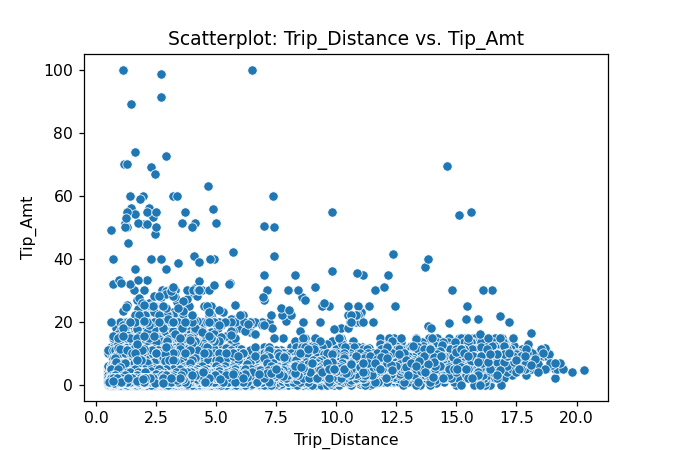

<IPython.core.display.Javascript object>


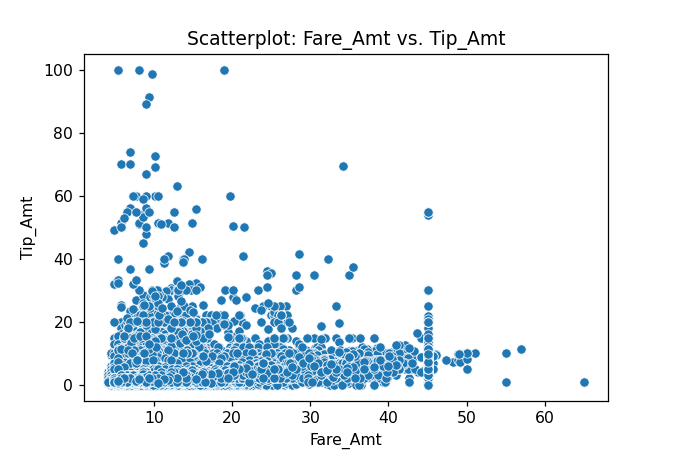

<IPython.core.display.Javascript object>


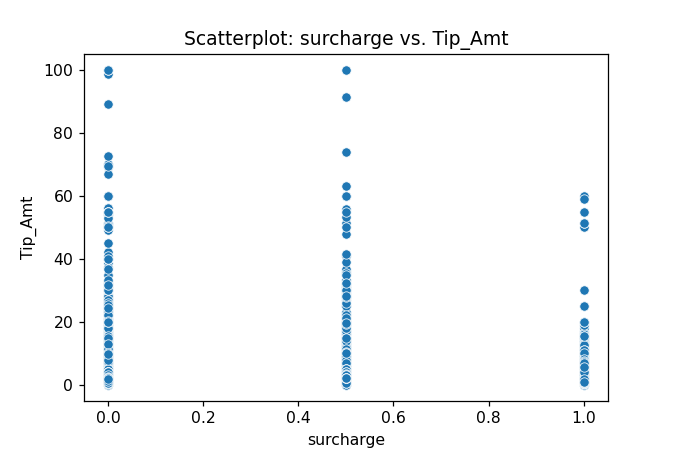

<IPython.core.display.Javascript object>


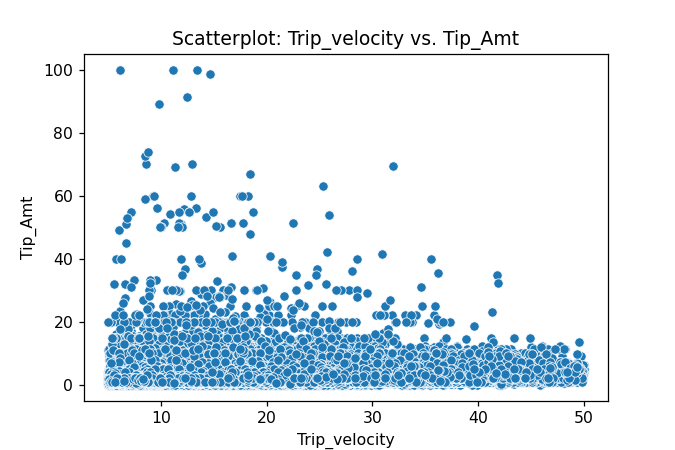

<IPython.core.display.Javascript object>


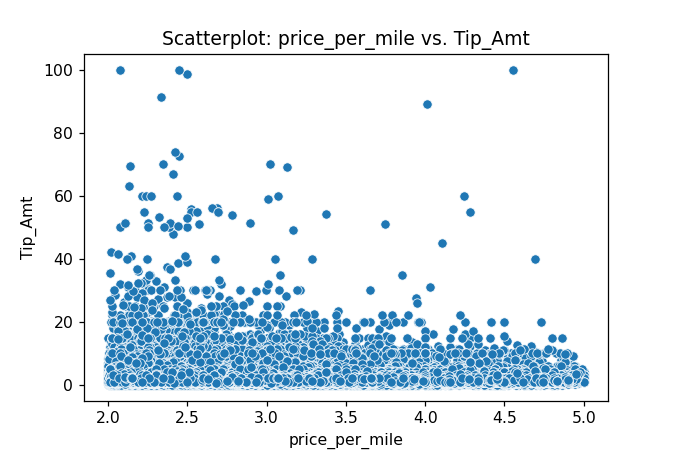

<IPython.core.display.Javascript object>


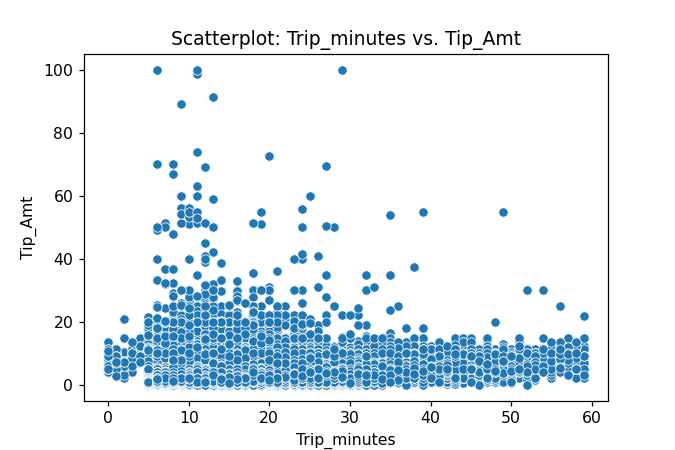

In [127]:
num_cols = dodatnie_tipy.select_dtypes(include='number').columns
num_cols = [col for col in num_cols if col != 'Tip_Amt']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=dodatnie_tipy[col], y=dodatnie_tipy['Tip_Amt'])
    plt.title(f'Scatterplot: {col} vs. Tip_Amt')
    plt.xlabel(col)
    plt.ylabel('Tip_Amt')
    plt.show()

In [17]:
df = dfML

# PRZYGOTOWANIE ZMIENNEJ DO KLASYFIKACJI:

In [20]:
df['tip_binary'] = (df['Tip_Amt'] > 0).astype(int)

features = [col for col in df.columns if col not in ['Tip_Amt', 'tip_binary']]

X = df[features]
y_class = df['tip_binary']

# PODZIAŁ NA ZBIÓR TRENINGOWY I TESTOWY (DLA MODELU KLASYFIKACJI):

In [21]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

# MODEL KLASYFIKACYJNY (RANDOM FOREST):

In [22]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)

acc = accuracy_score(y_test_c, y_pred_c)
print(f"\n=== MODEL KLASYFIKACYJNY (TIP>0) ===")
print(f"Accuracy klasyfikacji: {acc:.4f}")

print("\nClassification report:")
print(classification_report(y_test_c, y_pred_c))

cm = confusion_matrix(y_test_c, y_pred_c)
print("Macierz pomyłek:")
print(cm)


=== MODEL KLASYFIKACYJNY (TIP>0) ===
Accuracy klasyfikacji: 0.9939

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1137991
           1       0.98      0.99      0.98    283946

    accuracy                           0.99   1421937
   macro avg       0.99      0.99      0.99   1421937
weighted avg       0.99      0.99      0.99   1421937

Macierz pomyłek:
[[1131455    6536]
 [   2083  281863]]


# MODEL REGRESYJNY (RANDOM FOREST) - TYLKO GDZIE TIP>0

In [23]:
df_pos = df[df['Tip_Amt'] > 0].copy()

X_reg = df_pos[features]
y_reg = df_pos['Tip_Amt']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_r, y_train_r)

y_pred_r = reg.predict(X_test_r)

mse_r = mean_squared_error(y_test_r, y_pred_r)
rmse_r = np.sqrt(mse_r)
r2_r = r2_score(y_test_r, y_pred_r)

print(f"\n=== MODEL REGRESYJNY (TIP>0) ===")
print(f"RMSE (tylko tam, gdzie TIP>0): {rmse_r:.4f}")
print(f"R^2 (tylko tam, gdzie TIP>0): {r2_r:.4f}")


=== MODEL REGRESYJNY (TIP>0) ===
RMSE (tylko tam, gdzie TIP>0): 0.9330
R^2 (tylko tam, gdzie TIP>0): 0.1489


# EWALUACJA MODELU KLAS. I REG. ORAZ POŁĄCZENIE (PIPELINE)

<IPython.core.display.Javascript object>


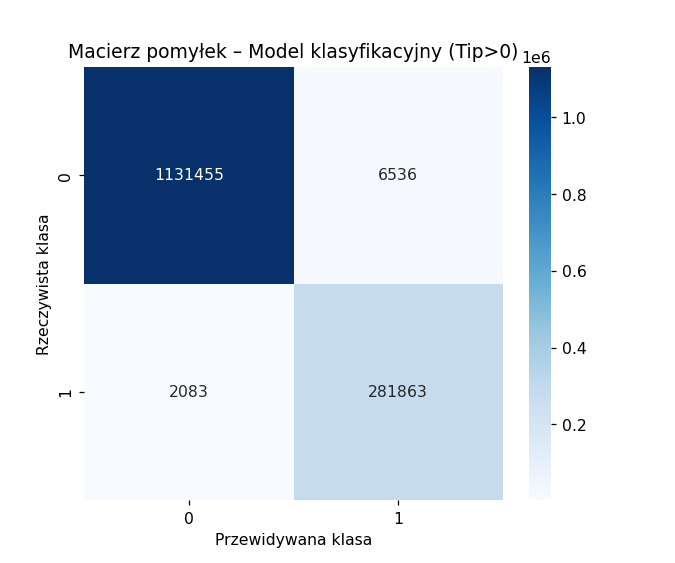

In [24]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek – Model klasyfikacyjny (Tip>0)')
plt.xlabel('Przewidywana klasa')
plt.ylabel('Rzeczywista klasa')
plt.show()

# WYKRES DLA MODELU REGRESYJNEGO (tylko TIP>0) Porównanie wartości rzeczywistych i przewidywanych

<IPython.core.display.Javascript object>


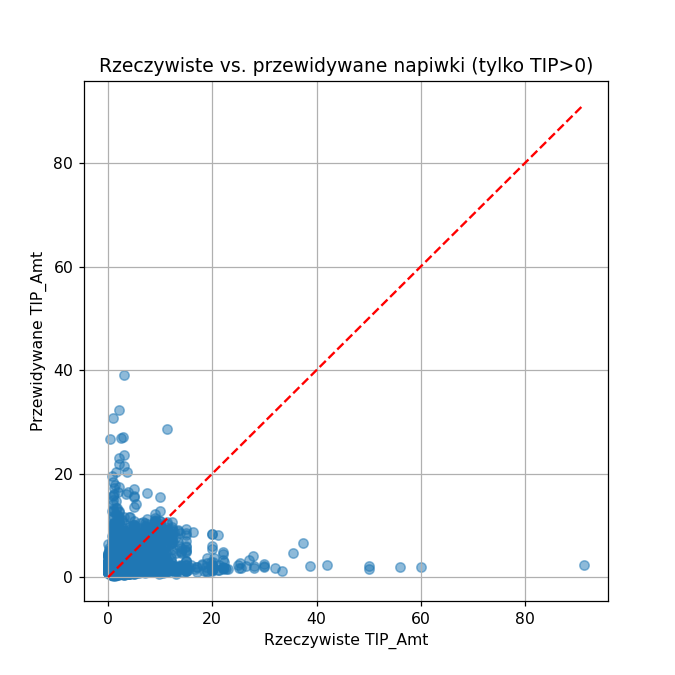

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([0, max(y_test_r)], [0, max(y_test_r)], 'r--')  # linia y=x
plt.title('Rzeczywiste vs. przewidywane napiwki (tylko TIP>0)')
plt.xlabel('Rzeczywiste TIP_Amt')
plt.ylabel('Przewidywane TIP_Amt')
plt.grid(True)
plt.show()

# POŁĄCZONY PIPELINE NA CAŁYM ZBIORZE TESTOWYM

In [26]:
y_test_full = df.loc[X_test_c.index, 'Tip_Amt'] 

y_pred_class_test = clf.predict(X_test_c)

df_test_c = X_test_c.copy()
df_test_c['Predicted_class'] = y_pred_class_test
df_test_c['Actual_TipAmt'] = y_test_full

mask_tip_pred = (df_test_c['Predicted_class'] == 1)
df_test_pos = df_test_c[mask_tip_pred].copy()

X_test_pos_for_reg = df_test_pos[features]
y_pred_reg_for_pos = reg.predict(X_test_pos_for_reg)

tip_predictions_pipeline = pd.Series(data=0, index=df_test_c.index, dtype=float)
tip_predictions_pipeline.loc[mask_tip_pred] = y_pred_reg_for_pos

y_true_full = df_test_c['Actual_TipAmt']
mse_full = mean_squared_error(y_true_full, tip_predictions_pipeline)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_true_full, tip_predictions_pipeline)

print(f"\n=== POŁĄCZONY PIPELINE (KLASYFIKACJA + REGRESJA) ===")
print(f"RMSE (cały zbiór testowy): {rmse_full:.4f}")
print(f"R^2 (cały zbiór testowy): {r2_full:.4f}")


=== POŁĄCZONY PIPELINE (KLASYFIKACJA + REGRESJA) ===
RMSE (cały zbiór testowy): 0.3199
R^2 (cały zbiór testowy): 0.8598


# WYKRES RZECZYWISTE vs. PRZEWIDYWANE (POŁĄCZONY PIPELINE)

<IPython.core.display.Javascript object>


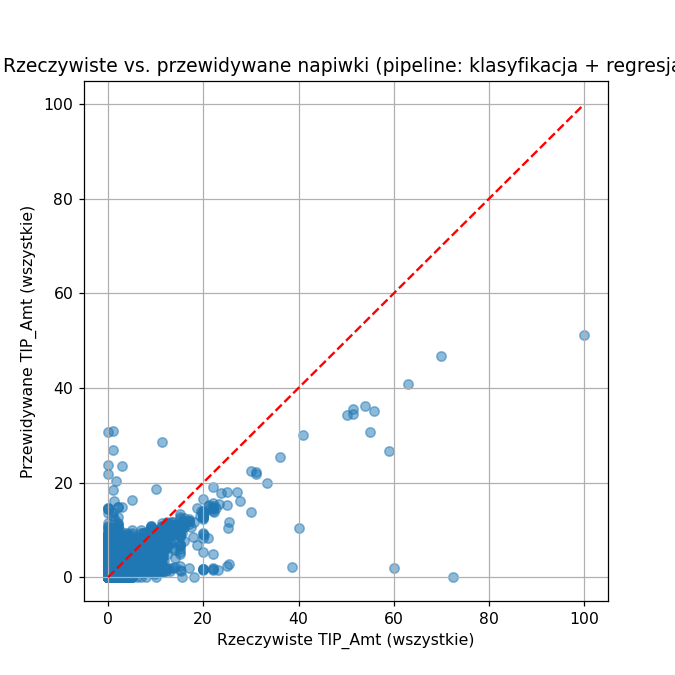

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(y_true_full, tip_predictions_pipeline, alpha=0.5)
max_val = max(max(y_true_full), max(tip_predictions_pipeline)) 
plt.plot([0, max_val], [0, max_val], 'r--')
plt.title('Rzeczywiste vs. przewidywane napiwki (pipeline: klasyfikacja + regresja)')
plt.xlabel('Rzeczywiste TIP_Amt (wszystkie)')
plt.ylabel('Przewidywane TIP_Amt (wszystkie)')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------

# Wnioski z modelu Machine Learning:

# Najlepszym modelem okazał się model DEEP_NN z najniższą wartością mean square error, a następnie pipeline, który kategoryzuje najpierw zmienną TIP ze względu na to czy wartość jej jest równa 0 czy jest dodatnia. Następnie dla wartości zkategoryzowanych jako dodatnie model przewiduje wartość napiwku.